# Bulk RNA-seq Stability Analysis: Distance-based Clustering (No Filter, with Single Cells)

## Overview
This notebook performs stability analysis of bulk RNA-seq data using distance-based clustering methods. The analysis includes hierarchical clustering, dendrogram visualization, and temporal distance plotting to assess the stability of gene expression patterns across timepoints and samples.

## Analysis Workflow
1. **Data Loading**: Load distance matrices, metadata, expression data, and variance-stabilized data
2. **Hierarchical Clustering**: Perform ward clustering on sample distances  
3. **Dendrogram Visualization**: Create colored dendrograms based on sample groupings
4. **Temporal Distance Analysis**: Plot distance changes over time for each sample
5. **Marker Gene Analysis**: Analyze expression patterns of differentially expressed genes
6. **Heatmap Visualization**: Generate expression heatmaps for key marker genes

## Input Files
- `bulk/stability_time_deseq2_limma_corrG_pca_distances_noFilter_wSC.tsv`: Distance matrix
- `bulk/stability_timepoints_meta_wSC.tsv`: Sample metadata with single cells
- `bulk/stability_timepoints_wSC.tsv`: Expression count matrix  
- `bulk/stability_time_deseq2_vsd_noFilter_wSC.tsv`: Variance stabilized data
- `stability_plots/[sample]_deseq2.tsv`: DESeq2 results for each sample

## Output Files
- `stability_plots/`: Directory containing all generated visualizations
- Dendrograms, distance plots, and expression heatmaps

## Configuration and Setup

In [ ]:
# =============================================================================
# CONFIGURATION AND PARAMETERS
# =============================================================================

import os
import numpy as np

# Set random seed for reproducibility
np.random.seed(42)

# File paths
DATA_DIR = "bulk"
OUTPUT_DIR = "stability_plots"
DISTANCE_FILE = "stability_time_deseq2_limma_corrG_pca_distances_noFilter_wSC.tsv"
META_FILE = "stability_timepoints_meta_wSC.tsv"
EXPR_FILE = "stability_timepoints_wSC.tsv"
VSD_FILE = "stability_time_deseq2_vsd_noFilter_wSC.tsv"

# Single cell data paths (optional - update as needed)
SC_POST_META_FILE = "/home/jjanssens/jjans/analysis/iNeuron_morphogens/final/scanpy/iGlut_post_dr_clustered_raw_merged_meta.tsv"
SC_PRE_META_FILE = "/home/jjanssens/jjans/analysis/iNeuron_morphogens/final/scanpy/iGlut_pre_dr_clustered_raw_merged_meta_fixed.tsv"

# GO term analysis paths (optional)
GO_TERM_DIR = "~/jjans/analysis/iNeuron_morphogens/revisions/maturation"
GO_TERMS = ['neuron_projection', 'neuron_differentiation', 'neurotransmitter_secretion', 'synapse_assembly']

# Analysis parameters
N_TOP_MARKERS = 10  # Number of top markers per sample
N_TIME_GENES = 40   # Number of early/late genes for time analysis
TIMEPOINTS = [10, 21, 28, 35, 42, 49]  # Age timepoints in days

# Plot parameters
DPI = 350
FIGURE_WIDTH = 15
FIGURE_HEIGHT = 4
HEATMAP_WIDTH = 20
HEATMAP_HEIGHT = 5

# Create output directory if it doesn't exist
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

print("Configuration loaded successfully!")
print(f"Output directory: {OUTPUT_DIR}")
print(f"Using distance file: {DISTANCE_FILE}")
print(f"Analysis timepoints: {TIMEPOINTS}")

In [ ]:
# =============================================================================
# LIBRARY IMPORTS
# =============================================================================

# Core data analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Clustering and distance analysis
import scipy.spatial.distance as ssd
from scipy.cluster import hierarchy
import scipy.cluster.hierarchy as sch

print("Libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Matplotlib version: {mpl.__version__}")

## 1. Data Loading and Initial Setup

In [ ]:
# =============================================================================
# DATA LOADING
# =============================================================================

print("Loading analysis data...")

# Load distance matrix (using corrected gene expression)
distance_file_path = os.path.join(DATA_DIR, DISTANCE_FILE)
if os.path.exists(distance_file_path):
    df = pd.read_csv(distance_file_path, sep="\t", index_col=0)
    print(f"✓ Distance matrix loaded: {df.shape}")
else:
    raise FileNotFoundError(f"Distance matrix not found: {distance_file_path}")

# Load metadata
meta_file_path = os.path.join(DATA_DIR, META_FILE)
if os.path.exists(meta_file_path):
    meta = pd.read_csv(meta_file_path, sep="\t", index_col=0)
    print(f"✓ Metadata loaded: {meta.shape}")
else:
    raise FileNotFoundError(f"Metadata not found: {meta_file_path}")

# Load expression data
expr_file_path = os.path.join(DATA_DIR, EXPR_FILE)
if os.path.exists(expr_file_path):
    expr = pd.read_csv(expr_file_path, sep="\t", index_col=0)
    print(f"✓ Expression data loaded: {expr.shape}")
else:
    raise FileNotFoundError(f"Expression data not found: {expr_file_path}")

# Load variance-stabilized data
vsd_file_path = os.path.join(DATA_DIR, VSD_FILE)
if os.path.exists(vsd_file_path):
    vsd = pd.read_csv(vsd_file_path, sep="\t", index_col=0)
    print(f"✓ VSD data loaded: {vsd.shape}")
else:
    raise FileNotFoundError(f"VSD data not found: {vsd_file_path}")

print("All data loaded successfully!")

In [ ]:
# =============================================================================
# MARKER GENE COLLECTION
# =============================================================================

print("Collecting marker genes from DESeq2 results...")

sample_markers_all = []
samples_processed = 0

for sample_id in set(meta['sample']):
    marker_file = os.path.join(OUTPUT_DIR, f"{sample_id}_deseq2.tsv")
    
    if os.path.exists(marker_file):
        # Load DESeq2 results for this sample
        marker_df = pd.read_csv(marker_file, sep="\t", index_col=0)
        
        # Filter for upregulated genes (positive log2FC)
        marker_df_pos = marker_df.loc[marker_df['log2FoldChange'] > 0]
        
        # Sort by adjusted p-value and take top N markers
        marker_df_pos_sig = marker_df_pos.sort_values(by='padj')
        sample_markers = list(marker_df_pos_sig.head(n=N_TOP_MARKERS).index)
        
        sample_markers_all.extend(sample_markers)
        samples_processed += 1
        print(f"  ✓ Sample {sample_id}: {len(sample_markers)} markers")
    else:
        print(f"  ⚠ Warning: Marker file not found for sample {sample_id}")

print(f"Collected {len(sample_markers_all)} total marker genes from {samples_processed} samples")
print(f"Unique marker genes: {len(set(sample_markers_all))}")

## 2. Sample Color Configuration and Clustering Setup

In [ ]:
# =============================================================================
# COLOR CONFIGURATION FOR VISUALIZATION
# =============================================================================

# Sample ID mapping
sample2ID = {
    '1': 'p1_D4', '2': 'p1_D8', '3': 'p1_D10',
    '4': 'p1_B4', '5': 'p1_B8', '6': 'p1_B10',
    '7': 'p3_C2', '8': 'p3_F2', '9': 'p3_D1',
    '10': 'p3_F4', '11': 'p3_G1', '12': 'p3_G10'
}

# Fill colors for sample visualization
sample_fillcolors = {
    'p1_D4': '#ffffff', 'p1_D8': '#66557d', 'p1_D10': '#6199b4',
    'p1_B4': '#ffd762', 'p1_B8': '#ab8c62', 'p1_B10': '#a8b180',
    'p3_C2': '#ffffff', 'p3_F2': '#ffffff', 'p3_D1': '#cc623f',
    'p3_F4': '#9a7da7', 'p3_G1': '#ffffff', 'p3_G10': '#b8b78b'
}

# Border/outline colors
sample_BMcolors = {
    'p1_D4': '#CBCCCC', 'p1_D8': '#CBCCCC', 'p1_D10': '#CBCCCC',
    'p1_B4': '#CBCCCC', 'p1_B8': '#CBCCCC', 'p1_B10': '#CBCCCC',
    'p3_C2': '#4E835E', 'p3_F2': '#8DC7DD', 'p3_D1': '#8DC7DD',
    'p3_F4': '#8DC7DD', 'p3_G1': '#102A4D', 'p3_G10': '#102A4D'
}

# Create color mapping for dendrogram leaves
basic_colors = ['red', 'green', 'blue', 'cyan', 'magenta', 'yellow', 
                'black', 'lightblue', 'orange', 'purple', 'brown', 'pink']

leaf_colors = {}
for sample, color in zip(list(set(meta['sample'])), basic_colors):
    sample_samples = list(meta.loc[meta['sample'] == sample].index)
    for sample_name in sample_samples:
        leaf_colors[sample_name] = color

print("Color configuration completed:")
print(f"  Sample mappings: {len(sample2ID)} samples")
print(f"  Leaf colors: {len(leaf_colors)} assignments")

# Set matplotlib parameters
mpl.rcParams['pdf.fonttype'] = 42  # Ensure PDF fonts are embedded

In [ ]:
# Prepare distance matrix for clustering analysis
print("Preparing distance matrix for clustering...")
distance_matrix = df
print(f"Distance matrix shape: {distance_matrix.shape}")
print(f"Distance matrix samples: {list(distance_matrix.index[:5])}...")

In [ ]:
# =============================================================================
# HIERARCHICAL CLUSTERING PREPARATION
# =============================================================================

def square_to_condensed(square_matrix):
    """
    Convert a square distance matrix to condensed form for scipy clustering.
    
    Parameters:
        square_matrix: Square symmetric distance matrix
    
    Returns:
        condensed_matrix: Upper triangle of distance matrix in vector form
    """
    # Ensure the matrix is square
    assert square_matrix.shape[0] == square_matrix.shape[1], "Distance matrix must be square"
    
    # Use the upper triangle indices to extract the condensed form
    triu_indices = np.triu_indices(square_matrix.shape[0], k=1)
    condensed_matrix = square_matrix[triu_indices]
    
    return condensed_matrix

# Convert distance matrix to condensed form for clustering
print("Converting distance matrix to condensed form...")
condensed_distance_matrix = square_to_condensed(distance_matrix.values)
print(f"Condensed matrix size: {condensed_distance_matrix.shape[0]} pairwise distances")

# Perform hierarchical clustering using Ward method
print("Performing hierarchical clustering with Ward linkage...")
linkage_matrix = sch.linkage(condensed_distance_matrix, method='ward')
print(f"Linkage matrix shape: {linkage_matrix.shape}")
print("Hierarchical clustering completed successfully!")


## 3. Hierarchical Clustering Analysis

## 4. Dendrogram Visualization

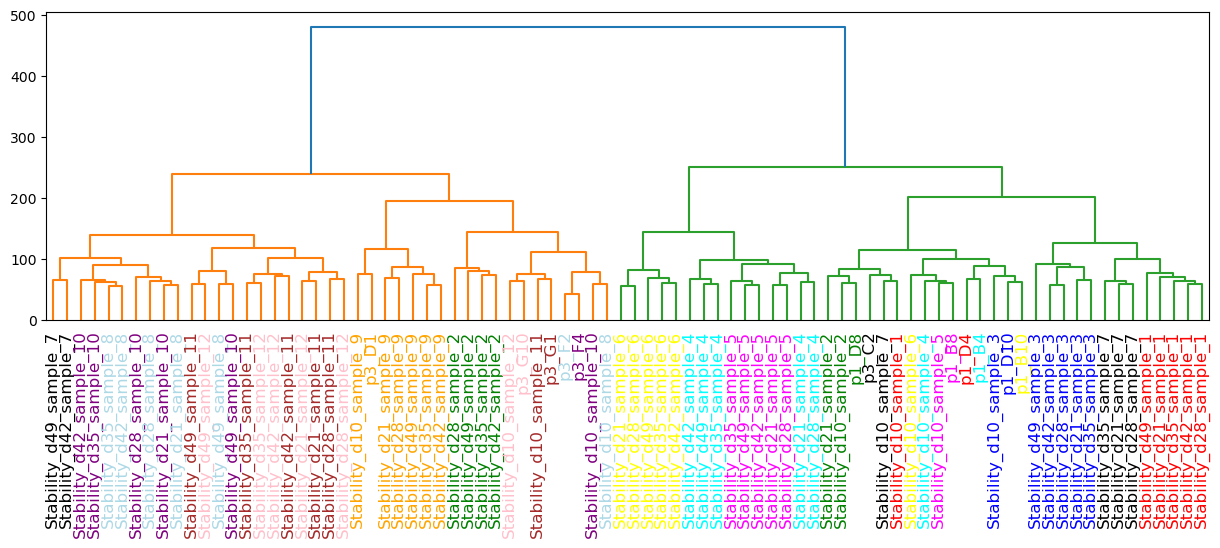

In [ ]:
# =============================================================================
# DENDROGRAM VISUALIZATION
# =============================================================================

def create_colored_dendrogram(linkage_matrix, sample_labels, leaf_colors, output_name):
    """
    Create a dendrogram with custom leaf label colors.
    
    Parameters:
        linkage_matrix: Hierarchical clustering linkage matrix
        sample_labels: Sample labels for dendrogram leaves
        leaf_colors: Dictionary mapping sample names to colors
        output_name: Output filename for saving
    """
    plt.figure(figsize=(FIGURE_WIDTH, FIGURE_HEIGHT))
    
    # Create the dendrogram
    dendrogram = sch.dendrogram(
        linkage_matrix,
        labels=sample_labels,
        leaf_rotation=90,  # Rotate leaf labels for better readability
        leaf_font_size=12  # Font size for leaf labels
    )
    
    # Apply custom colors to leaf labels
    ax = plt.gca()
    x_labels = ax.get_xmajorticklabels()
    
    dendrogram_labels = []
    for label in x_labels:
        txt = label.get_text()
        if txt in leaf_colors:
            color_code = leaf_colors[txt]
            label.set_color(color_code)
        dendrogram_labels.append(txt)
    
    plt.title("Hierarchical Clustering Dendrogram", fontsize=14, fontweight='bold')
    plt.xlabel("Samples", fontsize=12)
    plt.ylabel("Distance", fontsize=12)
    
    # Save the plot
    output_path = os.path.join(OUTPUT_DIR, f"{output_name}.png")
    plt.savefig(output_path, dpi=DPI, bbox_inches='tight', pad_inches=0.1)
    print(f"✓ Dendrogram saved: {output_path}")
    
    plt.show()
    plt.close()
    
    return dendrogram_labels

# Generate colored dendrogram
print("Creating colored dendrogram...")
dendrogram_labels = create_colored_dendrogram(
    linkage_matrix, 
    df.index, 
    leaf_colors, 
    "dendrogram_colored_by_sample_noFilter_wSC"
)


## 5. Temporal Distance Analysis

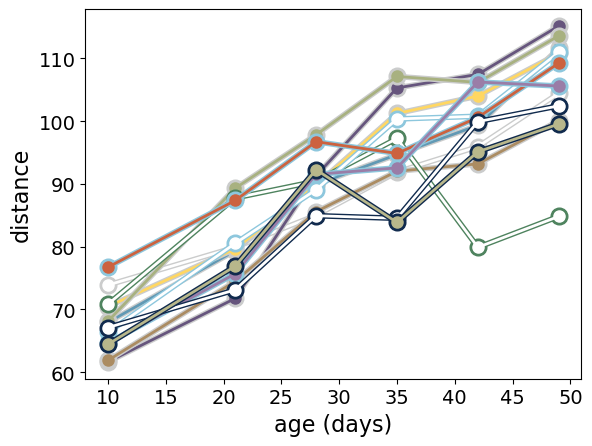

In [ ]:
# =============================================================================
# TEMPORAL DISTANCE ANALYSIS
# =============================================================================

def plot_temporal_distances(samples_dict, timepoints, distance_df, meta_df, 
                           output_name, title_suffix="", ylim=None):
    """
    Plot distance vs time for specified samples.
    
    Parameters:
        samples_dict: Dictionary mapping sample IDs to display names
        timepoints: List of timepoints to plot
        distance_df: Distance matrix DataFrame
        meta_df: Metadata DataFrame
        output_name: Output filename
        title_suffix: Additional title text
        ylim: Y-axis limits (optional)
    """
    plt.figure(figsize=(FIGURE_WIDTH, FIGURE_HEIGHT))
    
    for sample in samples_dict.keys():
        sample_name = f"sample_{sample}"
        sample_timepoints = [x for x in distance_df.index if x.endswith(sample_name)]
        sample_timepoints = list(meta_df.loc[sample_timepoints].sort_values(by='t_int').index)
        
        if len(sample_timepoints) > 0:
            distances = distance_df.loc[samples_dict[sample], sample_timepoints]
            fill_color = sample_fillcolors[samples_dict[sample]]
            line_color = sample_BMcolors[samples_dict[sample]]
            
            # Plot with outline and fill
            plt.plot(timepoints, distances, '-o', color=line_color, 
                    linewidth=4, markersize=12, alpha=0.8)
            plt.plot(timepoints, distances, '-o', label=samples_dict[sample], 
                    color=fill_color, linewidth=2, markersize=8)
    
    plt.xlabel("Age (days)", fontsize=16)
    plt.ylabel("Distance", fontsize=16)
    plt.title(f"Distance vs Time{title_suffix}", fontsize=14, fontweight='bold')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    if ylim:
        plt.ylim(ylim)
    
    # Save plots in multiple formats
    png_path = os.path.join(OUTPUT_DIR, f"{output_name}.png")
    pdf_path = os.path.join(OUTPUT_DIR, f"{output_name}.pdf")
    
    plt.savefig(png_path, dpi=DPI, bbox_inches='tight', pad_inches=0.1)
    plt.savefig(pdf_path, dpi=DPI, bbox_inches='tight', pad_inches=0.1)
    
    print(f"✓ Distance plot saved: {png_path}")
    plt.show()
    plt.close()

# Generate comprehensive temporal distance plot
print("Creating temporal distance analysis plots...")

# All samples distance plot
plot_temporal_distances(
    sample2ID, 
    TIMEPOINTS, 
    df, 
    meta, 
    "distance_vs_screen_corrG",
    " (All Samples)"
)

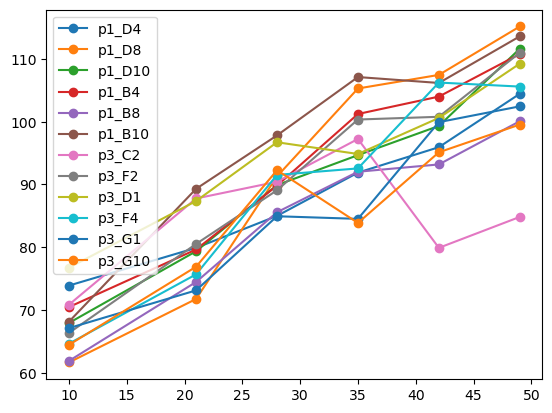

In [ ]:
time = [10,21,28,35,42,49]
# Generate grouped distance plots for better visualization
print("Creating grouped temporal distance plots...")

# Group 1: Samples 1-6 (first batch)
samples_group1 = {str(i): sample2ID[str(i)] for i in range(1, 7)}
plot_temporal_distances(
    samples_group1, 
    TIMEPOINTS, 
    df, 
    meta, 
    "distance_vs_time_group1",
    " (Samples 1-6)",
    ylim=(60, 120)
)

# Group 2: Samples 7-12 (second batch)
samples_group2 = {str(i): sample2ID[str(i)] for i in range(7, 13)}
plot_temporal_distances(
    samples_group2, 
    TIMEPOINTS, 
    df, 
    meta, 
    "distance_vs_time_group2",
    " (Samples 7-12)",
    ylim=(60, 120)
)

# All samples with legend
plt.figure(figsize=(FIGURE_WIDTH, FIGURE_HEIGHT))
for sample in sample2ID.keys():
    sample_name = f"sample_{sample}"
    sample_timepoints = [x for x in df.index if x.endswith(sample_name)]
    sample_timepoints = list(meta.loc[sample_timepoints].sort_values(by='t_int').index)
    
    if len(sample_timepoints) > 0:
        distances = df.loc[sample2ID[sample], sample_timepoints]
        plt.plot(TIMEPOINTS, distances, '-o', label=sample2ID[sample])

plt.xlabel("Age (days)", fontsize=16)
plt.ylabel("Distance", fontsize=16)
plt.title("Distance vs Time (All Samples with Legend)", fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

legend_plot_path = os.path.join(OUTPUT_DIR, "distance_vs_time_all_with_legend.png")
plt.savefig(legend_plot_path, dpi=DPI, bbox_inches='tight', pad_inches=0.1)
print(f"✓ Legend plot saved: {legend_plot_path}")
plt.show()
plt.close()


In [ ]:
# =============================================================================
# MARKER GENE HEATMAP VISUALIZATION
# =============================================================================

print("Creating marker gene expression heatmap...")

# Prepare marker gene expression data with Z-score normalization
vsd_plot = vsd.loc[sample_markers_all, dendrogram_labels]
vsd_plot_Z = (vsd_plot.T - vsd_plot.T.mean()) / vsd_plot.T.std()

print(f"Heatmap data shape: {vsd_plot_Z.shape}")
print(f"Using {len(sample_markers_all)} marker genes")
print(f"Samples ordered by dendrogram: {len(dendrogram_labels)}")


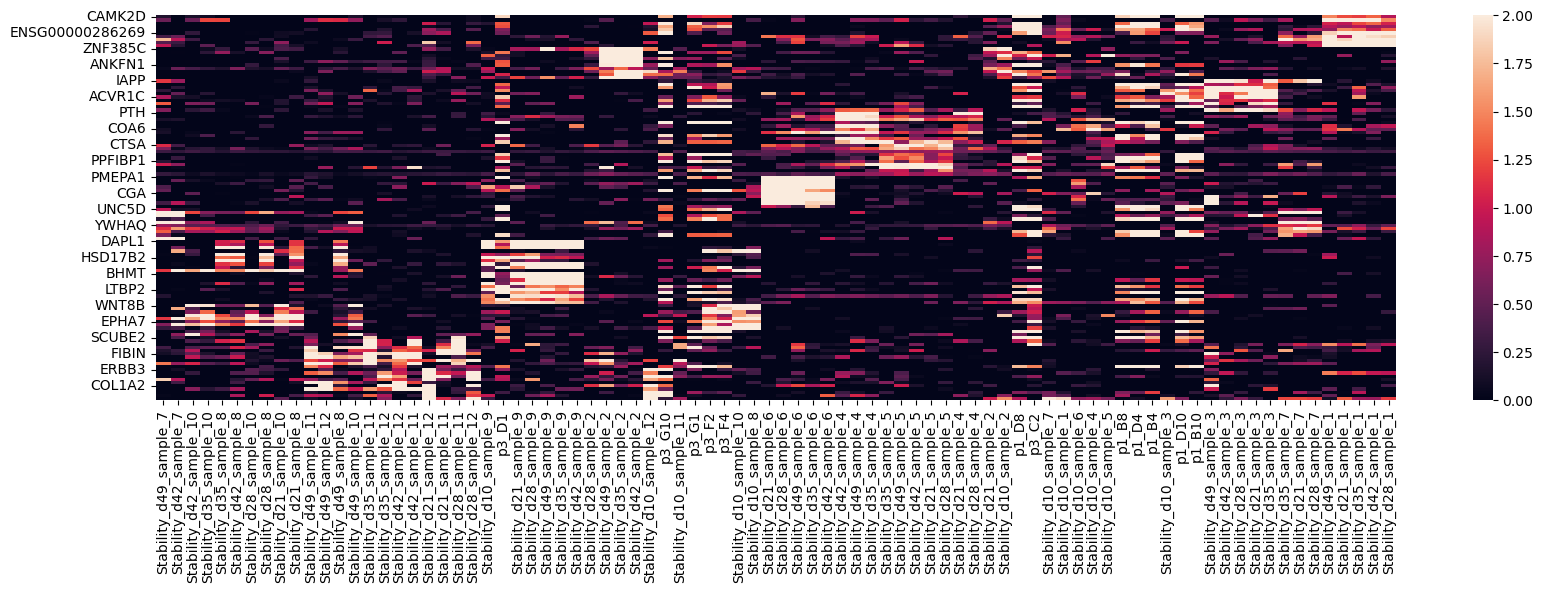

In [ ]:
plt.figure(figsize=(HEATMAP_WIDTH, HEATMAP_HEIGHT))
sns.heatmap(vsd_plot_Z.T, vmin=0, vmax=2, cmap='viridis')
plt.title("Marker Gene Expression (Dendrogram Order)", fontsize=14, fontweight='bold')
plt.xlabel("Samples", fontsize=12)
plt.ylabel("Marker Genes", fontsize=12)

# Save heatmap
heatmap_path = os.path.join(OUTPUT_DIR, "dendrogram_colored_by_sample_heatmap_markers_noFilter.png")
plt.savefig(heatmap_path, dpi=DPI, bbox_inches='tight', pad_inches=0.1)
print(f"✓ Marker gene heatmap saved: {heatmap_path}")
plt.show()
plt.close()


## 5. Temporal Distance Analysis

In [ ]:
# =============================================================================
# PREPARE SAMPLES FOR TEMPORAL ANALYSIS
# =============================================================================

print("Preparing samples for temporal analysis...")

# Sort samples by sample ID and time for consistent ordering
sorted_samples = list(meta.sort_values(by=['sample', 't_int']).index)
sorted_samples = [x for x in sorted_samples if x in vsd.columns]

print(f"Sorted samples for analysis: {len(sorted_samples)}")
print(f"Sample order: {sorted_samples[:5]}...") # Show first 5 as example

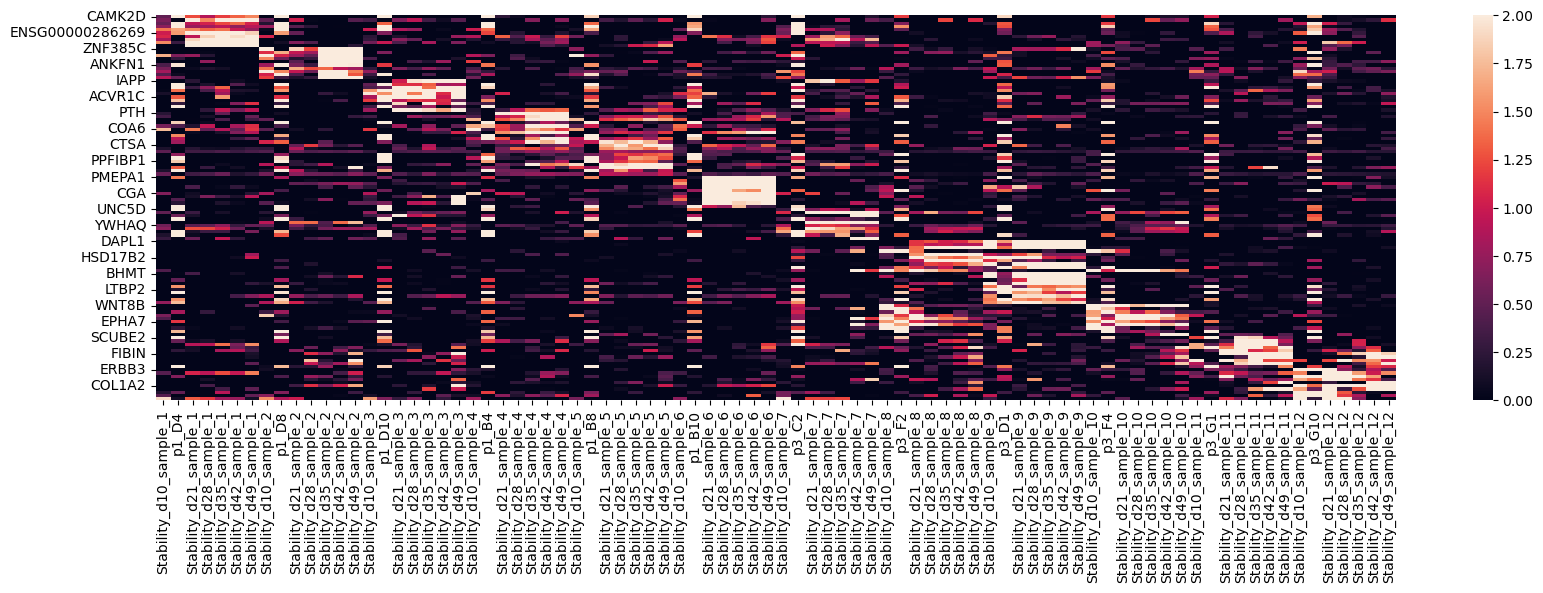

In [ ]:
# Generate marker gene heatmap with samples sorted by time
print("Creating time-ordered marker gene heatmap...")

vsd_plot = vsd.loc[sample_markers_all, sorted_samples]
vsd_plot_Z = (vsd_plot.T - vsd_plot.T.mean()) / vsd_plot.T.std()

plt.figure(figsize=(HEATMAP_WIDTH, HEATMAP_HEIGHT))
sns.heatmap(vsd_plot_Z.T, vmin=0, vmax=2, cmap='viridis')
plt.title("Marker Gene Expression (Time-Sorted Order)", fontsize=14, fontweight='bold')
plt.xlabel("Samples (Time-Sorted)", fontsize=12)
plt.ylabel("Marker Genes", fontsize=12)

# Save time-sorted heatmap
time_heatmap_path = os.path.join(OUTPUT_DIR, "sample_heatmap_markers_sorted_noFilter.png")
plt.savefig(time_heatmap_path, dpi=DPI, bbox_inches='tight', pad_inches=0.1)
print(f"✓ Time-sorted heatmap saved: {time_heatmap_path}")
plt.show()
plt.close()


In [ ]:
# =============================================================================
# TIME-DIFFERENTIAL GENE ANALYSIS
# =============================================================================

print("Loading and processing time-differential genes...")

# Load time DESeq2 results
time_deseq2_file = os.path.join(OUTPUT_DIR, "deseq2_time.tsv")
if os.path.exists(time_deseq2_file):
    time_deseq2 = pd.read_csv(time_deseq2_file, sep="\t")
    
    # Calculate signed p-value for ranking
    time_deseq2['signed_pval'] = np.sign(time_deseq2['log2FoldChange']) * -np.log10(time_deseq2['pvalue'])
    
    print(f"✓ Time DESeq2 results loaded: {time_deseq2.shape}")
    print(f"  Columns: {list(time_deseq2.columns)}")
else:
    print(f"⚠ Warning: Time DESeq2 file not found: {time_deseq2_file}")
    time_deseq2 = None


In [ ]:
# Select early and late genes based on temporal differential expression
if time_deseq2 is not None:
    print("Selecting early and late genes...")
    
    # Get early genes (negative signed p-value, downregulated over time)
    early_genes = list(time_deseq2.sort_values(by='signed_pval').index[:N_TIME_GENES])
    
    # Get late genes (positive signed p-value, upregulated over time) 
    late_genes = list(time_deseq2.sort_values(by='signed_pval', ascending=False).index[:N_TIME_GENES])
    
    # Combine early and late genes
    time_genes = early_genes + late_genes
    
    # Filter for genes present in expression data
    time_genes = [x for x in time_genes if x in vsd.index]
    
    print(f"✓ Selected {len(early_genes)} early genes")
    print(f"✓ Selected {len(late_genes)} late genes") 
    print(f"✓ Total time genes in expression data: {len(time_genes)}")
else:
    print("⚠ Skipping time gene analysis - DESeq2 results not available")
    time_genes = []


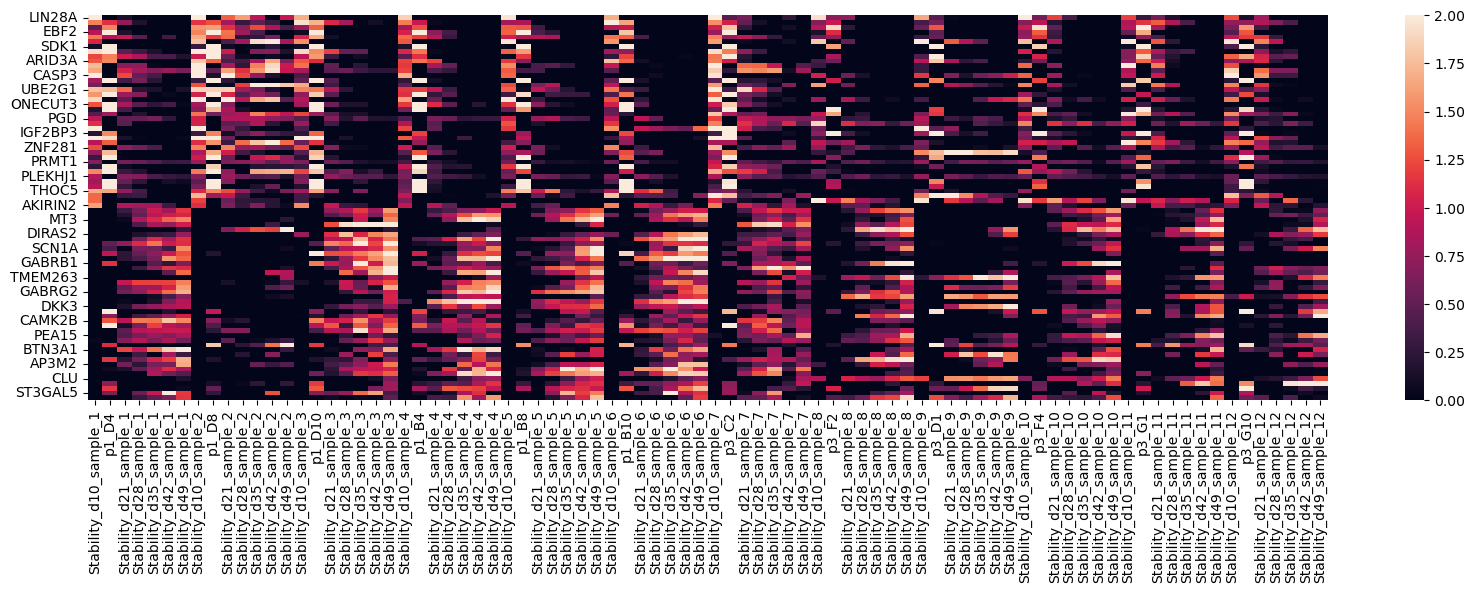

In [ ]:
# Generate temporal gene expression heatmap
if len(time_genes) > 0:
    print("Creating temporal gene expression heatmap...")
    
    vsd_plot = vsd.loc[time_genes, sorted_samples]
    vsd_plot_Z = (vsd_plot.T - vsd_plot.T.mean()) / vsd_plot.T.std()
    
    plt.figure(figsize=(HEATMAP_WIDTH, HEATMAP_HEIGHT))
    sns.heatmap(vsd_plot_Z.T, vmin=0, vmax=2, cmap='viridis')
    plt.title("Temporal Gene Expression (Early/Late Genes)", fontsize=14, fontweight='bold')
    plt.xlabel("Samples (Time-Sorted)", fontsize=12)
    plt.ylabel("Temporal Genes", fontsize=12)
    
    # Save temporal heatmap
    temporal_heatmap_path = os.path.join(OUTPUT_DIR, "sample_heatmap_markers_time_sorted_noFilter.png")
    plt.savefig(temporal_heatmap_path, dpi=DPI, bbox_inches='tight', pad_inches=0.1)
    print(f"✓ Temporal heatmap saved: {temporal_heatmap_path}")
    plt.show()
    plt.close()
else:
    print("⚠ Skipping temporal heatmap - no time genes available")

## 6. Single Cell Marker Analysis

In [ ]:
# =============================================================================
# SINGLE CELL MARKER GENE LOADING
# =============================================================================

print("Loading single cell marker genes...")

# Define single cell data paths
SC_DATA_BASE = "/home/jjanssens/jjans/analysis/iNeuron_morphogens/final"

# Single cell marker files
sc_marker_files = {
    'post': os.path.join(SC_DATA_BASE, "marker_genes", "iGlut_post_dr_clustered_raw_merged_markers.tsv"),
    'pre': os.path.join(SC_DATA_BASE, "marker_genes", "iGlut_pre_dr_clustered_raw_merged_markers.tsv")
}

# Single cell metadata files
sc_meta_files = {
    'post': os.path.join(SC_DATA_BASE, "scanpy", "iGlut_post_dr_clustered_raw_merged_meta.tsv"),
    'pre': os.path.join(SC_DATA_BASE, "scanpy", "iGlut_pre_dr_clustered_raw_merged_meta_fixed.tsv")
}

# Load single cell data with error handling
sc_markers = {}
sc_meta = {}

for condition in ['post', 'pre']:
    marker_file = sc_marker_files[condition]
    meta_file = sc_meta_files[condition]
    
    if os.path.exists(marker_file) and os.path.exists(meta_file):
        sc_markers[condition] = pd.read_csv(marker_file, sep="\t", index_col=0)
        sc_meta[condition] = pd.read_csv(meta_file, sep="\t", index_col=0)
        
        print(f"✓ {condition.upper()} markers loaded: {sc_markers[condition].shape}")
        print(f"✓ {condition.upper()} metadata loaded: {sc_meta[condition].shape}")
    else:
        print(f"⚠ Warning: Single cell {condition} files not found")
        sc_markers[condition] = None
        sc_meta[condition] = None

# Check if any single cell data was loaded
sc_data_available = any(sc_markers[c] is not None for c in ['post', 'pre'])
print(f"Single cell data available: {sc_data_available}")

,sample,species,gene_count,tscp_count,mread_count,bc1_well,bc2_well,bc3_well,bc1_wind,bc2_wind,...,M_CHIR,M_RA,M_FGF8,M_BMP4,M_SHH,M_PM,tSNE_1,tSNE_2,umap_1,umap_2
01_01_41__s1,iGlut_pre,hg38,1456,2184,2946,A1,A1,D5,1,1,...,0.0,0,0,50,0,0,10.189884,39.231434,13.276781,-0.856798
01_01_68__s1,iGlut_pre,hg38,1693,2776,3762,A1,A1,F8,1,1,...,0.0,0,0,50,0,0,25.132082,32.402280,14.830362,5.908925
01_01_76__s1,iGlut_pre,hg38,1454,2196,2981,A1,A1,G4,1,1,...,0.0,0,0,50,0,0,5.797632,52.208040,16.393394,-1.702099
01_01_83__s1,iGlut_pre,hg38,2391,4048,5592,A1,A1,G11,1,1,...,0.0,0,0,50,0,0,6.855360,43.492870,13.618956,-2.668232
01_01_92__s1,iGlut_pre,hg38,769,1076,1503,A1,A1,H8,1,1,...,0.0,0,0,50,0,0,25.081343,29.805347,14.698254,5.868345


In [ ]:
# =============================================================================
# SAMPLE PREPARATION FOR SC ANALYSIS
# =============================================================================

print("Preparing samples for single cell marker analysis...")

# Get unique samples from metadata
meta_sorted = meta.sort_values(by=['sample', 't_int'])
samples = list(set(meta_sorted['sample']))
samples = [str(x) for x in samples]

print(f"Unique samples for SC analysis: {samples}")
print(f"Sample to ID mapping: {sample2ID}")

In [ ]:
# Filter single cell markers for upregulated genes
if sc_data_available:
    print("Filtering single cell markers for upregulated genes...")
    
    for condition in ['post', 'pre']:
        if sc_markers[condition] is not None:
            # Filter for upregulated markers (positive log fold change)
            sc_markers[condition] = sc_markers[condition].loc[
                sc_markers[condition]['logfoldchanges'] > 0
            ].copy()
            print(f"✓ {condition.upper()} upregulated markers: {sc_markers[condition].shape[0]}")
else:
    print("⚠ Skipping marker filtering - no single cell data available")


In [ ]:
# =============================================================================
# SINGLE CELL MARKER COLLECTION FOR BULK SAMPLES
# =============================================================================

print("Collecting single cell markers for bulk samples...")

# Initialize collections
sample_markers_all_sc = []
sample_markers_all_sc_dict = {}
all_markers_plot_post = []
all_markers_plot_pre = []

def get_top_cluster_markers(sc_markers_df, sc_meta_df, sample_id, condition, top_clusters=3, markers_per_cluster=10):
    """Get top markers from most abundant clusters for a given sample."""
    markers = []
    
    if sc_markers_df is None or sc_meta_df is None:
        return markers
    
    try:
        # Get top clusters by abundance for this sample
        sample_clusters = list(
            sc_meta_df.loc[sc_meta_df['parse_id'] == sample_id, 'final_clustering']
            .value_counts()
            .head(n=top_clusters)
            .index
        )
        
        # Collect markers from each top cluster
        for cluster in sample_clusters:
            cluster_markers = list(
                sc_markers_df.loc[sc_markers_df['cluster_old'] == cluster]
                .index[:markers_per_cluster]
            )
            # Filter for genes present in bulk expression data
            cluster_markers = [x for x in cluster_markers if x in vsd.index]
            markers.extend(cluster_markers)
            print(f"  ✓ {condition} cluster {cluster}: {len(cluster_markers)} markers")
        
    except Exception as e:
        print(f"  ⚠ Error processing {sample_id} {condition}: {e}")
    
    return markers

# Process each sample
if sc_data_available:
    for sample in samples:
        sample_id = sample2ID[sample]
        sample_markers = []
        
        print(f"Processing sample {sample} ({sample_id})...")
        
        # Determine condition based on sample ID
        if 'p1' in sample_id:  # Post samples
            markers = get_top_cluster_markers(
                sc_markers['post'], sc_meta['post'], sample_id, 'post'
            )
            sample_markers.extend(markers)
            all_markers_plot_post.extend(markers)
            
        elif 'p3' in sample_id:  # Pre samples  
            markers = get_top_cluster_markers(
                sc_markers['pre'], sc_meta['pre'], sample_id, 'pre'
            )
            sample_markers.extend(markers)
            all_markers_plot_pre.extend(markers)
        
        # Store markers for this sample
        sample_markers_all_sc.extend(sample_markers)
        sample_markers_all_sc_dict[sample] = sample_markers
    
    print(f"✓ Total SC markers collected: {len(sample_markers_all_sc)}")
    print(f"✓ Unique SC markers: {len(set(sample_markers_all_sc))}")
    print(f"✓ Post markers: {len(set(all_markers_plot_post))}")
    print(f"✓ Pre markers: {len(set(all_markers_plot_pre))}")
else:
    print("⚠ Skipping single cell marker collection - no SC data available")


## 7. Consolidated Heatmap Visualizations

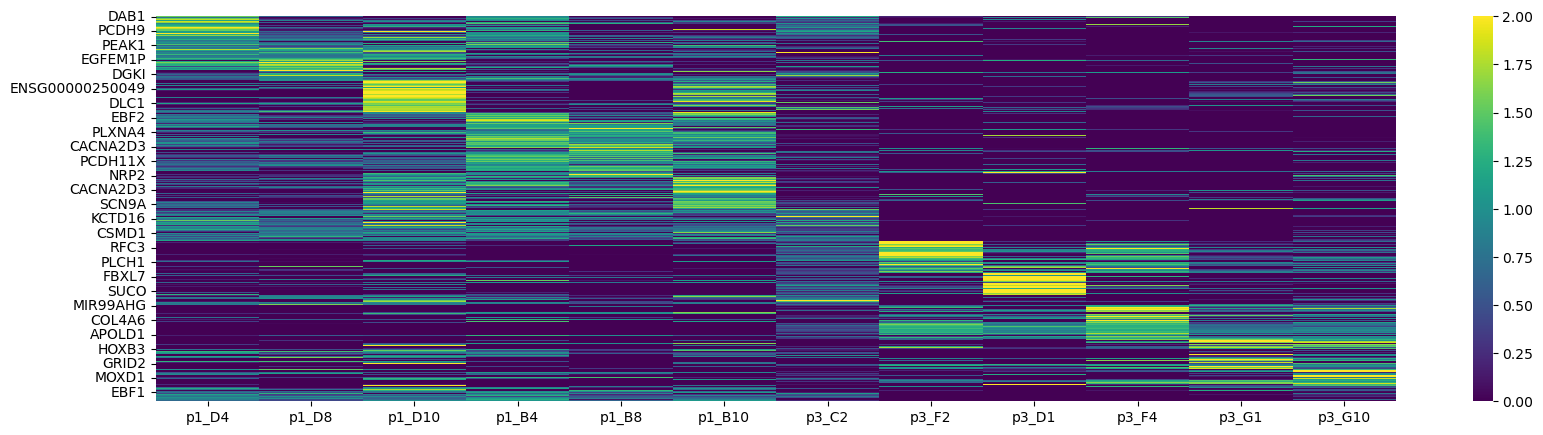

In [ ]:
# =============================================================================
# CONSOLIDATED GENE SET HEATMAPS
# =============================================================================

print("Creating consolidated gene set heatmaps...")

# Define gene sets for visualization
gene_sets = {
    'Single Cell Markers': sample_markers_all_sc if 'sample_markers_all_sc' in locals() else [],
    'Temporal Genes': time_genes if 'time_genes' in locals() else [],
    'Bulk Markers': sample_markers_all if 'sample_markers_all' in locals() else []
}

# Create individual heatmaps for each gene set
for gene_set_name, genes in gene_sets.items():
    if len(genes) > 0:
        # Filter genes present in expression data
        genes_filtered = [x for x in genes if x in vsd.index]
        
        if len(genes_filtered) > 0:
            print(f"Creating {gene_set_name} heatmap ({len(genes_filtered)} genes)...")
            
            vsd_plot = vsd.loc[genes_filtered, sorted_samples]
            vsd_plot_Z = (vsd_plot.T - vsd_plot.T.mean()) / vsd_plot.T.std()
            
            plt.figure(figsize=(HEATMAP_WIDTH, HEATMAP_HEIGHT))
            sns.heatmap(vsd_plot_Z.T, vmin=0, vmax=2, cmap='Greys')
            plt.title(f"{gene_set_name} Expression Heatmap", fontsize=14, fontweight='bold')
            plt.xlabel("Samples (Time-Sorted)", fontsize=12)
            plt.ylabel("Genes", fontsize=12)
            
            # Save heatmap
            filename = f"sample_heatmap_{gene_set_name.lower().replace(' ', '_')}_sorted_noFilter.png"
            heatmap_path = os.path.join(OUTPUT_DIR, filename)
            plt.savefig(heatmap_path, dpi=DPI, bbox_inches='tight', pad_inches=0.1)
            print(f"✓ {gene_set_name} heatmap saved: {heatmap_path}")
            plt.show()
            plt.close()
        else:
            print(f"⚠ No genes found for {gene_set_name} in expression data")
    else:
        print(f"⚠ No genes available for {gene_set_name}")



In [103]:
sample_points = list(meta.loc[meta['sample']==1].index)
sample_points = [x for x in sample_points if x not in sc_samples]
sample_points = sorted(sample_points)

In [134]:
def qualheatmap(df,color_dict,figsize=(10,10),ax_heatmap=None):
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.colors import ListedColormap
    import seaborn as sns
    
    available_keys = []
    for col in df.columns:
        df_col_values = list(set(df[col]))
        available_keys = available_keys + df_col_values
    available_keys = list(set(available_keys))
    
    color_dict_annot = {}
    for key in available_keys:
        try:
            color_dict_annot[key] = color_dict[key]
        except:
            print(key+" has no matching color in color_dict")
    
    
    # Create a unique list of colors based on the color_dict
    unique_colors = np.unique(list(color_dict_annot.values()))
    unique_colors = [x for x in unique_colors if x!='#000000']

    # Create a custom colormap using ListedColormap
    cmap = ListedColormap(unique_colors)

    # Map categorical values to integer values
    value_mapping = {category: i for i, category in enumerate(unique_colors)}
    mapped_data = df.applymap(lambda x: value_mapping.get(color_dict_annot.get(x, 'white')))

    # Create the heatmap using seaborn
    if not ax_heatmap:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        print('adding on existing axis')

    heatmap = sns.heatmap(mapped_data,
                        cmap=cmap,
                        ax = ax_heatmap,
                        cbar=False) 
    # alternative: use imshow to plot heatmap
    #    heatmap = plt.imshow(mapped_data, cmap=cmap)

    # Set axis labels and title
    plt.xticks(np.arange(len(df.columns)), df.columns)
    plt.yticks(np.arange(len(df)), df.index)
    
    if not ax_heatmap:
        return fig
    

In [177]:
color_dict = {}
#color_dict['M_SHH'] = ['w',"#C2D9F7", "#98C1F0", "#4782DD", "#1D52A1"]
#color_dict['M_RA'] = ['w', "#aadce0","#72bcd5", "#528fad", "#376795"]
#color_dict['M_BMP4'] = ['w', "#ffe6b7", "#ffd353","#ffb242"]
#color_dict['M_XAV'] = ['w', "#f9b4c9","#d8527c","#9a133d"]
#color_dict['M_CHIR'] = ['w',"#dec5da", "#b695bc", "#90719f", "#574571"]
#color_dict['M_FGF8'] = ['w','#ffbbff','#ee7ae9','#b452cd','#8b008b']

color_dict['RA_4'] = "#376795"
color_dict['RA_3'] =  "#528fad"
color_dict['RA_2'] = "#72bcd5"
color_dict['RA_1'] = "#aadce0"

color_dict['BMP4_3'] = "#ffb242"
color_dict['BMP4_2'] = "#ffd353"
color_dict['BMP4_1'] = "#ffe6b7"

color_dict['XAV_3'] = "#9a133d"
color_dict['XAV_2'] = "#d8527c"
color_dict['XAV_1'] = "#f9b4c9"

color_dict['FGF8_1'] ='#ffbbff'
color_dict['FGF8_2'] ='#ee7ae9'
color_dict['FGF8_3'] ='#b452cd'
color_dict['FGF8_4'] ='#8b008b'

color_dict['CHIR_1'] = "#dec5da"
color_dict['CHIR_2'] = "#b695bc"
color_dict['CHIR_3'] = "#90719f"
color_dict['CHIR_4'] = "#574571"

color_dict['SHH_1'] = "#C2D9F7"
color_dict['SHH_2'] = "#98C1F0"
color_dict['SHH_3'] = "#4782DD"
color_dict['SHH_4'] = "#1D52A1"

color_dict['RA_4_CHIR'] = "#3c7c3d"
color_dict['RA_3_CHIR'] = "#669d62"
color_dict['RA_2_CHIR'] = "#9cc184"
color_dict['RA_1_CHIR'] = "#c2d6a4"

color_dict['FGF8_1_CHIR'] = "#cccccc"
color_dict['FGF8_2_CHIR'] = "#999999"
color_dict['FGF8_3_CHIR'] = "#666666"
color_dict['FGF8_4_CHIR'] = "#333333"


color_dict['XAV_3_FGF8'] = "#D8527C"
color_dict['RA_3_FGF8'] = "#183E6B"
color_dict['CHIR_2_FGF8'] = "#90719F"

color_dict['CycA'] = '#659E62'
color_dict['ctrl'] = '#FFFFFF'

color_dict['N2B27_SB_CHIR'] = '#102A4D'
color_dict['N2B27_2Si'] = '#8DC7DD'
color_dict['NIM'] = '#4E835E'


color_dict['mTeSR'] = '#CBCCCC'
color_dict['Other'] = '#CBCCCC'

color_dict['NGN2'] = 'royalblue'
color_dict['ASCL1'] = 'crimson'
color_dict['post'] = 'black'
color_dict['pre'] = 'white'

#col_FGF8 <- c("plum1", "orchid2", "mediumorchid3", "magenta4")
#col_RA_CHIR <- c("#3c7c3d", "#669d62", "#9cc184", "#c2d6a4")
#col_FGF8_CHIR <- c("gray80", "gray60", "gray40", "gray20")

#col_DV <- c("#ffb242", "#ffd353", "#ffe6b7", "gray90", "#C2D9F7", "#98C1F0", "#4782DD", "#1D52A1")
#col_AP <- c(col_XAV, "gray90", col_CHIR, col_RA, col_FGF8, col_RA_CHIR, col_FGF8_CHIR)

In [ ]:
# =============================================================================
# SINGLE CELL METADATA LOADING (OPTIONAL)
# =============================================================================

# Single cell data paths (update these paths as needed)
SC_POST_META_FILE = "/home/jjanssens/jjans/analysis/iNeuron_morphogens/final/scanpy/iGlut_post_dr_clustered_raw_merged_meta.tsv"
SC_PRE_META_FILE = "/home/jjanssens/jjans/analysis/iNeuron_morphogens/final/scanpy/iGlut_pre_dr_clustered_raw_merged_meta_fixed.tsv"

print("Loading single cell metadata for annotation...")

try:
    # Load single cell metadata
    sc_meta_post = pd.read_csv(SC_POST_META_FILE, sep="\t", index_col=0)
    sc_meta_pre = pd.read_csv(SC_PRE_META_FILE, sep="\t", index_col=0)
    
    print(f"✓ SC post metadata loaded: {sc_meta_post.shape}")
    print(f"✓ SC pre metadata loaded: {sc_meta_pre.shape}")
    
    sc_data_available = True
    
except FileNotFoundError as e:
    print(f"⚠ Single cell metadata files not found: {e}")
    print("Continuing without single cell annotation data")
    sc_data_available = False

,sample,species,gene_count,tscp_count,mread_count,bc1_well,bc2_well,bc3_well,bc1_wind,bc2_wind,...,M_CHIR,M_RA,M_FGF8,M_BMP4,M_SHH,M_PM,tSNE_1,tSNE_2,umap_1,umap_2
01_01_41__s1,iGlut_pre,hg38,1456,2184,2946,A1,A1,D5,1,1,...,0.0,0,0,50,0,0,10.189884,39.231434,13.276781,-0.856798
01_01_68__s1,iGlut_pre,hg38,1693,2776,3762,A1,A1,F8,1,1,...,0.0,0,0,50,0,0,25.132082,32.402280,14.830362,5.908925
01_01_76__s1,iGlut_pre,hg38,1454,2196,2981,A1,A1,G4,1,1,...,0.0,0,0,50,0,0,5.797632,52.208040,16.393394,-1.702099
01_01_83__s1,iGlut_pre,hg38,2391,4048,5592,A1,A1,G11,1,1,...,0.0,0,0,50,0,0,6.855360,43.492870,13.618956,-2.668232
01_01_92__s1,iGlut_pre,hg38,769,1076,1503,A1,A1,H8,1,1,...,0.0,0,0,50,0,0,25.081343,29.805347,14.698254,5.868345


In [193]:
sc_meta_post = sc_meta_post.groupby('parse_id').head(n=1)
sc_meta_post.index = sc_meta_post['parse_id']

sc_meta_pre = sc_meta_pre.groupby('parse_id').head(n=1)
sc_meta_pre.index = sc_meta_pre['parse_id']

sc_meta_post['TF'] = 'NGN2'
sc_meta_post['timing'] = 'post'

sc_meta_pre['TF'] = 'NGN2'
sc_meta_pre['timing'] = 'pre'

parse_meta = pd.concat([sc_meta_post,sc_meta_pre])

In [222]:
meta['sample_name'] = meta.index

In [223]:
meta['parse_id'] = [sample2ID[str(x)] for x in meta['sample']]
morphogens = ['M_XAV', 'M_CHIR', 'M_RA','M_FGF8', 'M_BMP4', 'M_SHH']
morphogens_summary = ['TF','timing','AP_axis','DV_axis','Basal_media']


In [224]:
meta.index = meta['parse_id']

In [225]:
meta[morphogens] = parse_meta.loc[meta['parse_id'],morphogens]
meta[morphogens_summary] = parse_meta.loc[meta['parse_id'],morphogens_summary]

In [226]:
bmeta = meta.loc[meta['genotype']=='409B2'].copy()

In [227]:
bmeta.index = bmeta['sample_name']

In [228]:
bmeta = bmeta.sort_values(by=['sample','t_int'])

/tmp/ipykernel_53280/851740362.py:31: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mapped_data = df.applymap(lambda x: value_mapping.get(color_dict_annot.get(x, 'white')))


adding on existing axis


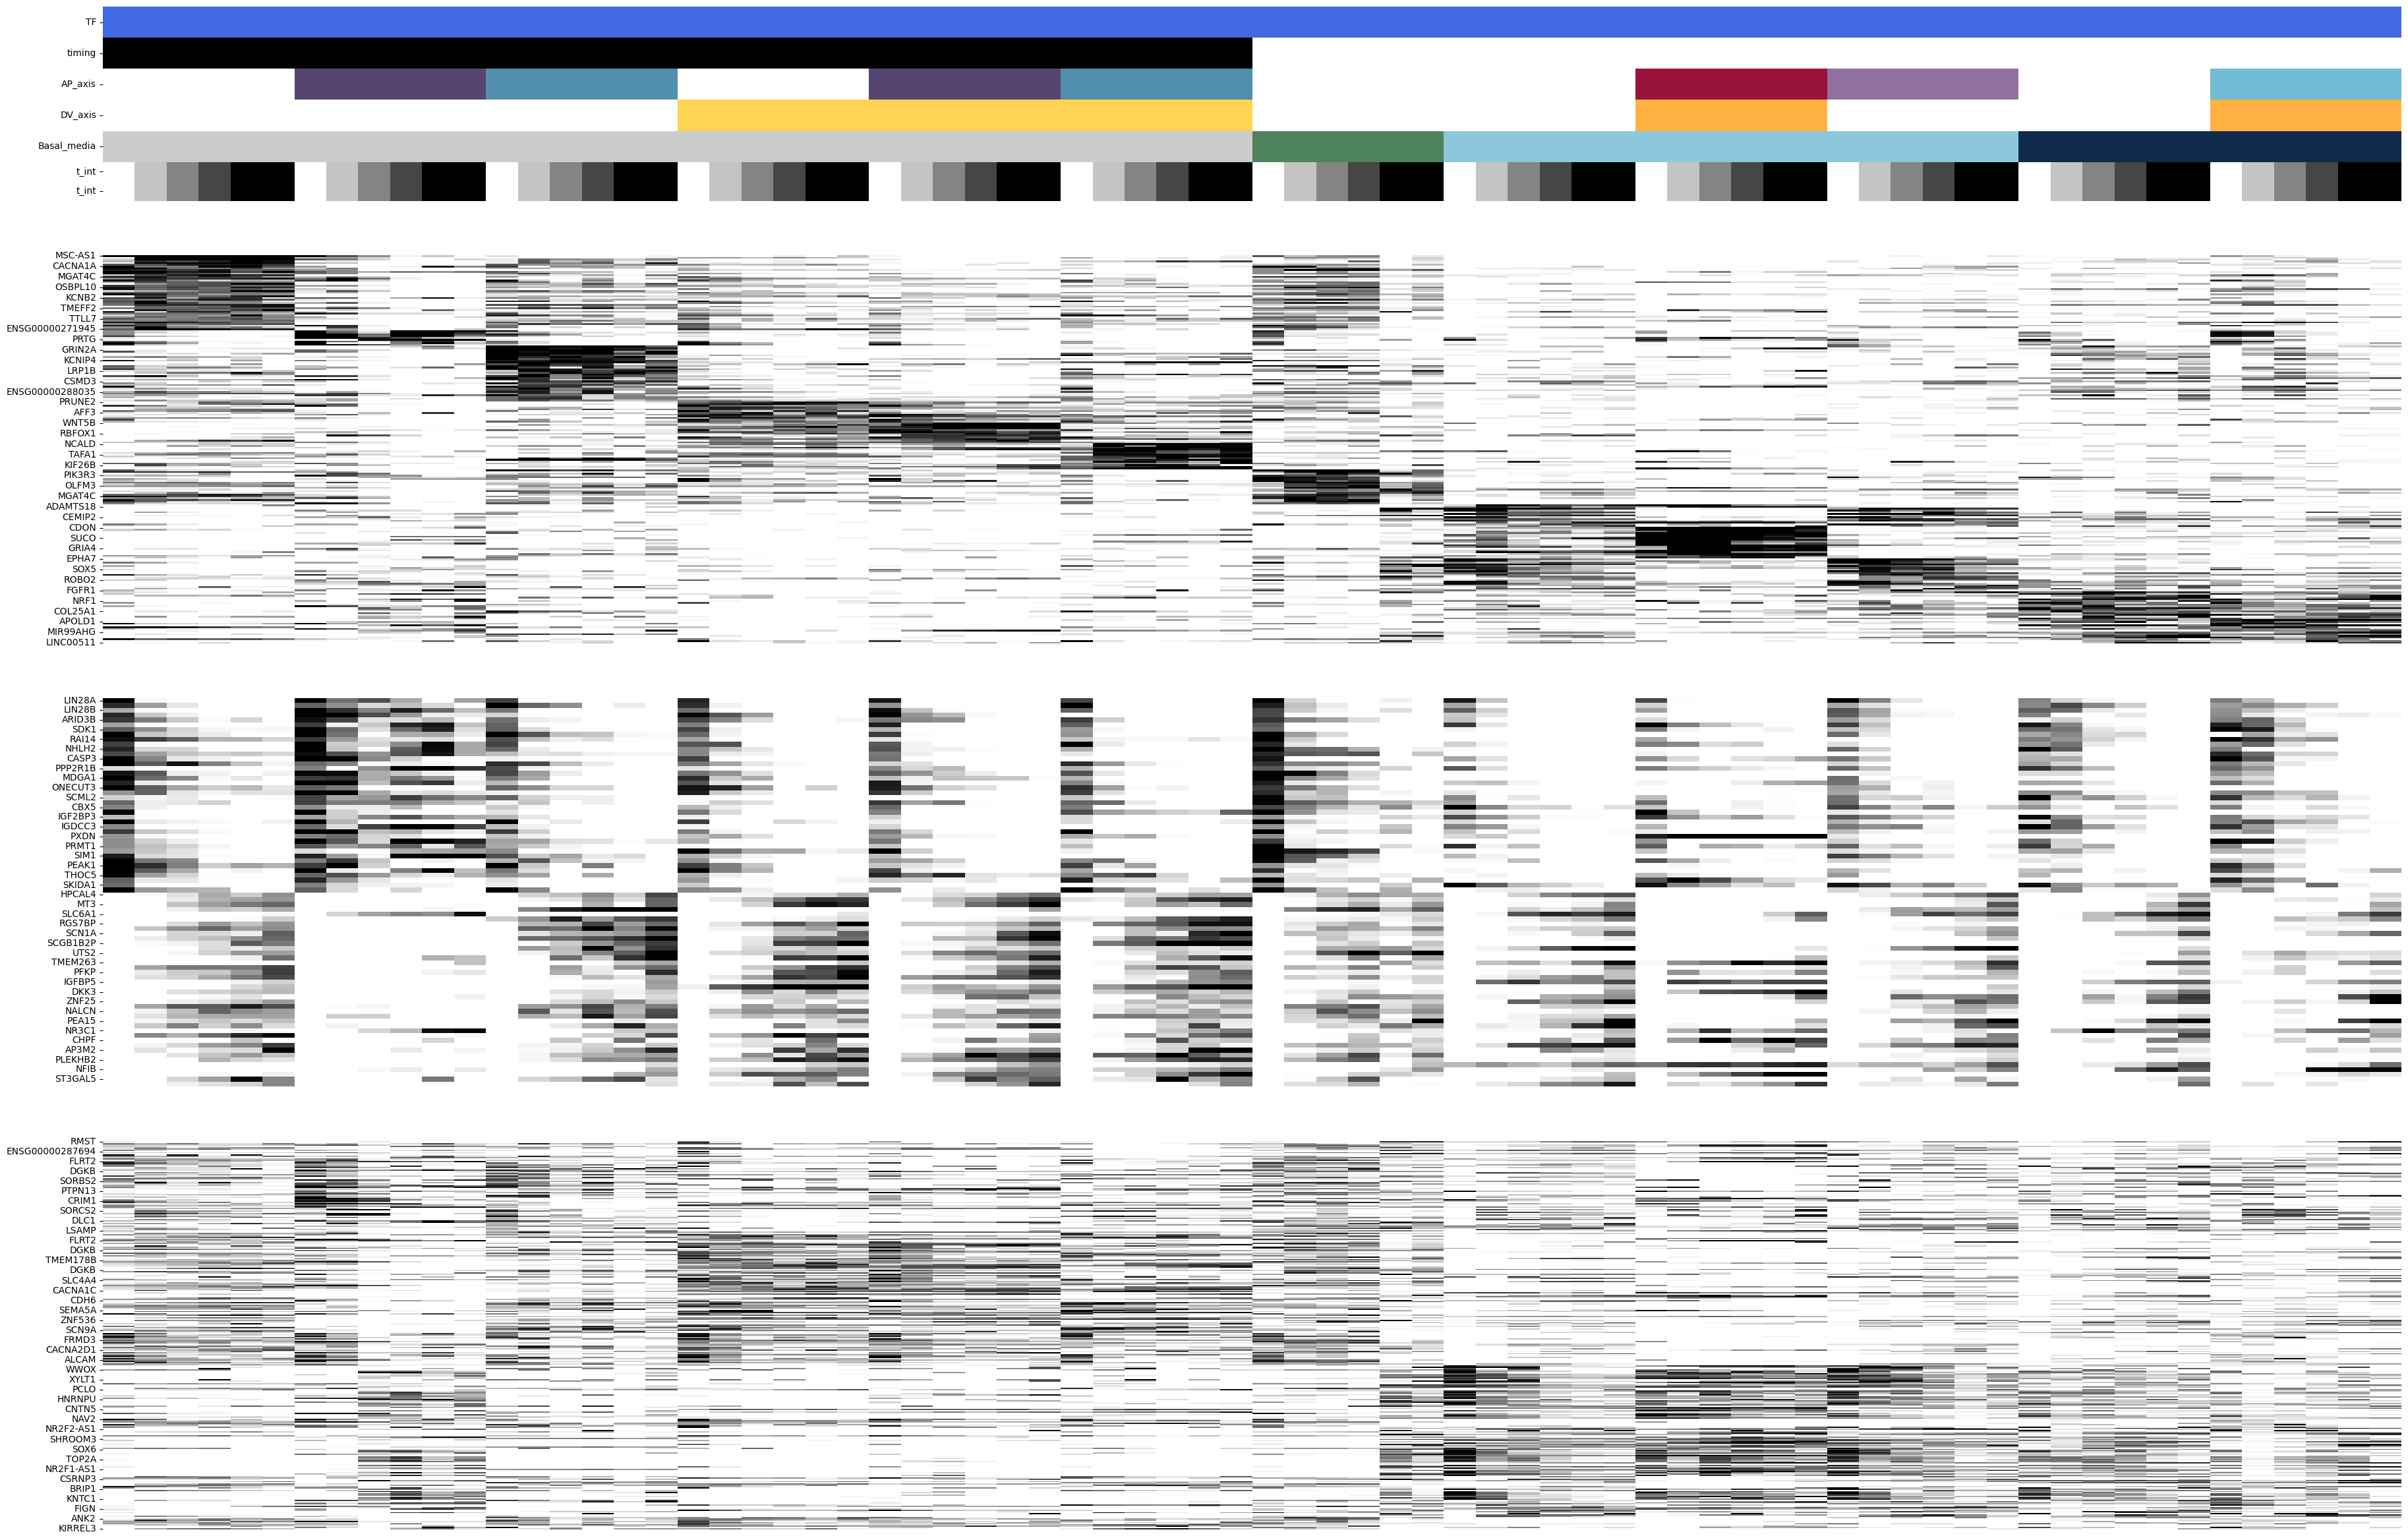

In [ ]:
# =============================================================================
# COMPREHENSIVE MULTI-PANEL HEATMAP VISUALIZATION
# =============================================================================

print("Creating comprehensive multi-panel heatmap with annotation...")

# Define layout parameters
empty_space = 0.7
height_ratios = [
    2,           # Annotation panel
    0.5,         # Time panel
    empty_space, # Spacer
    5,           # Stable markers heatmap
    empty_space, # Spacer
    5,           # Temporal genes heatmap
    empty_space, # Spacer
    5            # SC markers heatmap
]

white_axes = [2, 4, 6]  # Indices of spacer axes to hide

# Create multi-panel figure
fig, axs = plt.subplots(
    len(height_ratios), 1, 
    figsize=(45, 30), 
    gridspec_kw={'height_ratios': height_ratios, 'hspace': 0}
)

# Panel 1: Sample annotation heatmap
ax_annotation = axs[0]
if 'bmeta' in locals() and 'morphogens_summary' in locals():
    qualheatmap(
        bmeta.loc[sorted_samples_bulk, morphogens_summary].T,
        color_dict=color_dict,
        ax_heatmap=ax_annotation
    )
ax_annotation.set_xticks([])
ax_annotation.set_xticklabels([])

# Panel 2: Time annotation
ax_timemap = axs[1]
if 'bmeta' in locals():
    sns.heatmap(
        bmeta.loc[bmeta.index, ['t_int', 't_int']].T,
        vmax=42, vmin=10, cmap='Greys', cbar=False, ax=ax_timemap
    )

# Panel 3: Stable markers heatmap
ax_heatmap1 = axs[3]
if 'stable_markers' in locals() and len(stable_markers) > 0:
    vsd_plot = vsd.loc[stable_markers, sorted_samples_bulk]
    vsd_plot_Z = (vsd_plot.T - vsd_plot.T.mean()) / vsd_plot.T.std()
    sns.heatmap(vsd_plot_Z.T, vmin=0, vmax=2, cmap='Greys', cbar=False, ax=ax_heatmap1)
    ax_heatmap1.set_title('Stable Markers', fontsize=14, fontweight='bold')
ax_heatmap1.set_xticks([])
ax_heatmap1.set_xticklabels([])

# Panel 4: Temporal genes heatmap
ax_heatmap2 = axs[5]
if 'time_genes' in locals() and len(time_genes) > 0:
    vsd_plot = vsd.loc[time_genes, sorted_samples_bulk]
    vsd_plot_Z = (vsd_plot.T - vsd_plot.T.mean()) / vsd_plot.T.std()
    sns.heatmap(vsd_plot_Z.T, vmin=0, vmax=2, cmap='Greys', cbar=False, ax=ax_heatmap2)
    ax_heatmap2.set_title('Temporal Genes', fontsize=14, fontweight='bold')
ax_heatmap2.set_xticks([])
ax_heatmap2.set_xticklabels([])

# Panel 5: Single cell markers heatmap  
ax_heatmap3 = axs[7]
if 'sc_markers_all' in locals() and len(sc_markers_all) > 0:
    # Filter SC markers to exclude temporal and stable markers
    sc_markers_plot = [x for x in sc_markers_all if x not in time_genes]
    if 'stable_markers' in locals():
        sc_markers_plot = [x for x in sc_markers_plot if x not in stable_markers]
    
    if len(sc_markers_plot) > 0:
        vsd_plot = vsd.loc[sc_markers_plot, sorted_samples_bulk]
        vsd_plot_Z = (vsd_plot.T - vsd_plot.T.mean()) / vsd_plot.T.std()
        sns.heatmap(vsd_plot_Z.T, vmin=0, vmax=2, cmap='Greys', cbar=False, ax=ax_heatmap3)
        ax_heatmap3.set_title('Single Cell Markers', fontsize=14, fontweight='bold')
ax_heatmap3.set_xticks([])
ax_heatmap3.set_xticklabels([])

# Hide spacer axes
for ax_white_nr in white_axes:
    ax_white = axs[ax_white_nr]
    ax_white.set_xticks([])
    ax_white.set_yticks([])
    ax_white.set_xticklabels([])
    ax_white.set_yticklabels([])
    sns.despine(left=True, bottom=True, ax=ax_white)

# Save comprehensive heatmap
output_path = os.path.join(OUTPUT_DIR, "comprehensive_heatmap_markers_greys.png")
plt.savefig(output_path, dpi=DPI, bbox_inches='tight', pad_inches=0)
print(f"✓ Comprehensive heatmap saved: {output_path}")

plt.show()
plt.close()

In [237]:
go_term_genes_man = {}
for term in ['neuron_projection','neuron_differentiation','neurotransmitter_secretion','synapse_assembly']:
    np_genes = pd.read_csv("~/jjans/analysis/iNeuron_morphogens/revisions/maturation/"+term+".txt",sep="\t",header=None)
    np_genes = list(np_genes[1])
    go_term_genes_man[term] = np_genes

In [248]:
for term in go_term_genes_man.keys():
    np_genes = go_term_genes_man[term]
    np_genes = list(set(np_genes)&set(vsd.index))
    vsd_plot = vsd.loc[np_genes,sorted_samples_bulk]
    bmeta[term] = vsd_plot.sum()

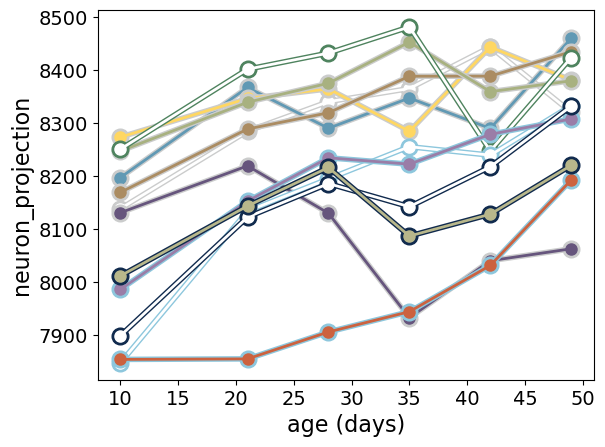

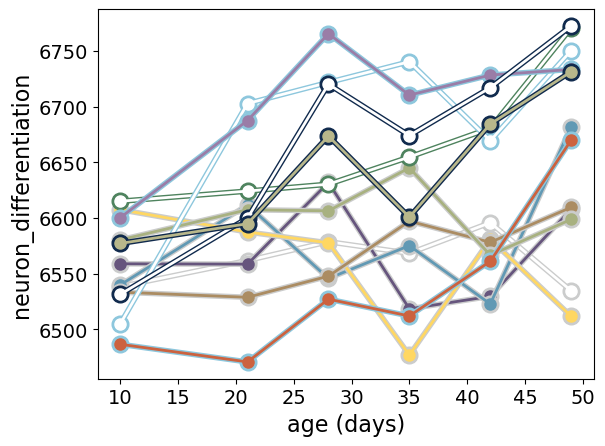

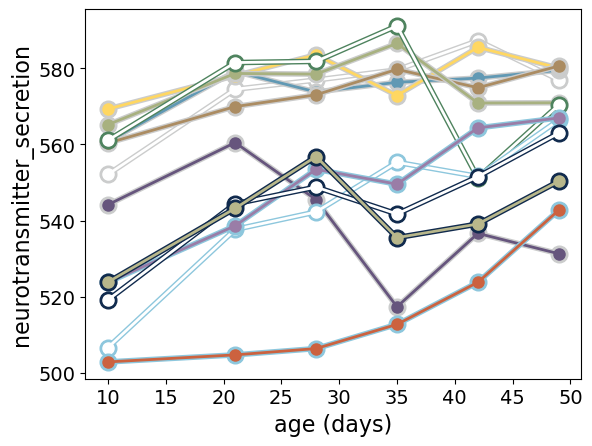

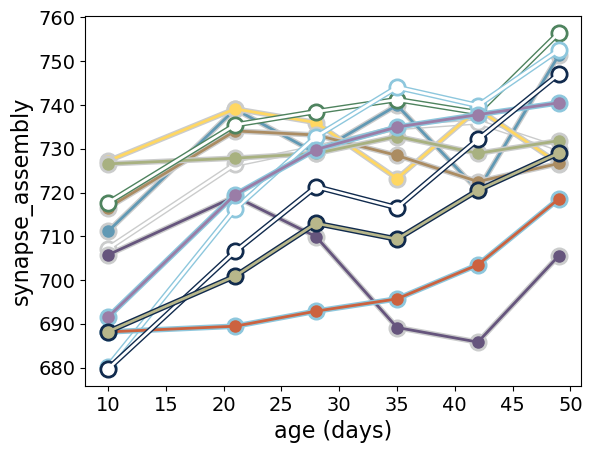

In [264]:
time = [10,21,28,35,42,49]
for term in go_term_genes_man.keys():

    for sample in sample2ID.keys():
        sample_name = "sample_"+str(sample)
        sample_timepoints = [x for x in df.index if x.endswith(sample_name)]
        sample_timepoints = list(bmeta.loc[sample_timepoints].sort_values(by='t_int').index)
        a = bmeta.loc[sample_timepoints,term]
        fill_color = sample_fillcolors[sample2ID[sample]]
        line_color = sample_BMcolors[sample2ID[sample]]
        plt.plot(time,a,'-o', color=line_color, linewidth=4,markersize=12)  # Outline with a thick black line
        plt.plot(time,a,'-o',label=sample2ID[sample],color=fill_color,linewidth=2,markersize=8)
    #plt.legend()
    plt.xlabel("age (days)",fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.ylabel(term,fontsize=16)
    plt.savefig("stability_plots/"+term+"_vsd_sum.png",dpi=350,bbox_inches='tight',pad_inches=0)
    plt.savefig("stability_plots/"+term+"_vsd_sum.pdf",dpi=350,bbox_inches='tight',pad_inches=0)
    plt.show()
    plt.close()

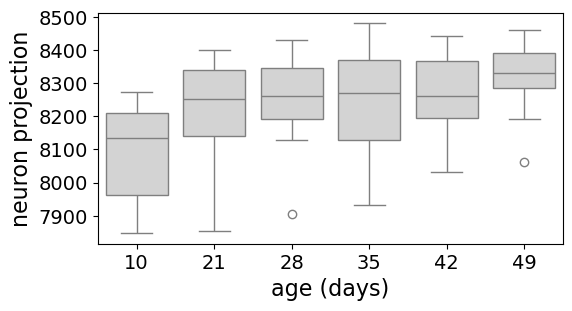

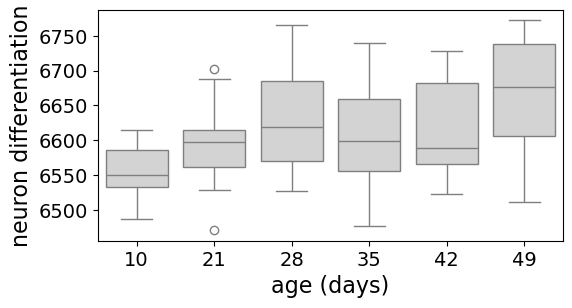

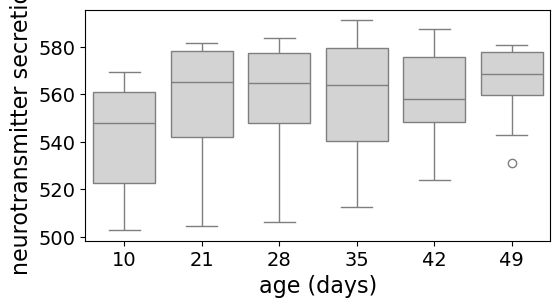

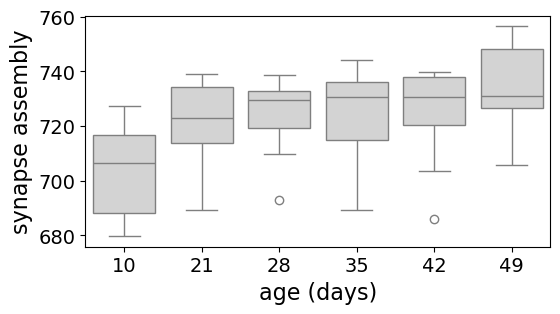

In [271]:
import re
for term in go_term_genes_man.keys():
    plt.figure(figsize=(6,3))
    sns.boxplot(x='t_int',y=term,data=bmeta,color='lightgrey')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.ylabel(re.sub("_"," ",term),fontsize=16)
    plt.xlabel("age (days)",fontsize=16)
    plt.savefig("stability_plots/"+term+"_vsd_sum_boxplot.png",dpi=350,bbox_inches='tight',pad_inches=0)
    plt.savefig("stability_plots/"+term+"_vsd_sum_boxplot.pdf",dpi=350,bbox_inches='tight',pad_inches=0)

    plt.show()
    plt.close()

In [249]:
bmeta

,t,sample,t_int,genotype,repl,sample_name,parse_id,M_XAV,M_CHIR,M_RA,...,M_SHH,TF,timing,AP_axis,DV_axis,Basal_media,synapse_assembly,neuron_projection,neuron_differentiation,neurotransmitter_secretion
sample_name,,,,,,,,,,,,,,,,,,,,,
Stability_d10_sample_1,d10,1,10,409B2,1,Stability_d10_sample_1,p1_D4,0.0,0.0,0,...,0,NGN2,post,ctrl,ctrl,mTeSR,707.224580,8138.267502,6538.338792,552.125228
Stability_d21_sample_1,d21,1,21,409B2,1,Stability_d21_sample_1,p1_D4,0.0,0.0,0,...,0,NGN2,post,ctrl,ctrl,mTeSR,726.476550,8284.769094,6561.793337,574.521222
Stability_d28_sample_1,d28,1,28,409B2,1,Stability_d28_sample_1,p1_D4,0.0,0.0,0,...,0,NGN2,post,ctrl,ctrl,mTeSR,730.262218,8340.438802,6578.683557,576.952342
Stability_d35_sample_1,d35,1,35,409B2,1,Stability_d35_sample_1,p1_D4,0.0,0.0,0,...,0,NGN2,post,ctrl,ctrl,mTeSR,734.844553,8365.273938,6568.308502,579.615461
Stability_d42_sample_1,d42,1,42,409B2,1,Stability_d42_sample_1,p1_D4,0.0,0.0,0,...,0,NGN2,post,ctrl,ctrl,mTeSR,736.142434,8443.809113,6595.809312,587.291837
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Stability_d21_sample_12,d21,12,21,409B2,1,Stability_d21_sample_12,p3_G10,0.0,0.0,10,...,0,NGN2,pre,RA_2,BMP4_3,N2B27_SB_CHIR,700.924426,8143.414998,6594.858936,543.203582
Stability_d28_sample_12,d28,12,28,409B2,1,Stability_d28_sample_12,p3_G10,0.0,0.0,10,...,0,NGN2,pre,RA_2,BMP4_3,N2B27_SB_CHIR,712.980648,8216.149103,6673.597150,556.829279
Stability_d35_sample_12,d35,12,35,409B2,1,Stability_d35_sample_12,p3_G10,0.0,0.0,10,...,0,NGN2,pre,RA_2,BMP4_3,N2B27_SB_CHIR,709.363000,8086.639558,6600.794075,535.499749


In [ ]:
go_term_genes_man

/tmp/ipykernel_53280/851740362.py:31: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mapped_data = df.applymap(lambda x: value_mapping.get(color_dict_annot.get(x, 'white')))


adding on existing axis


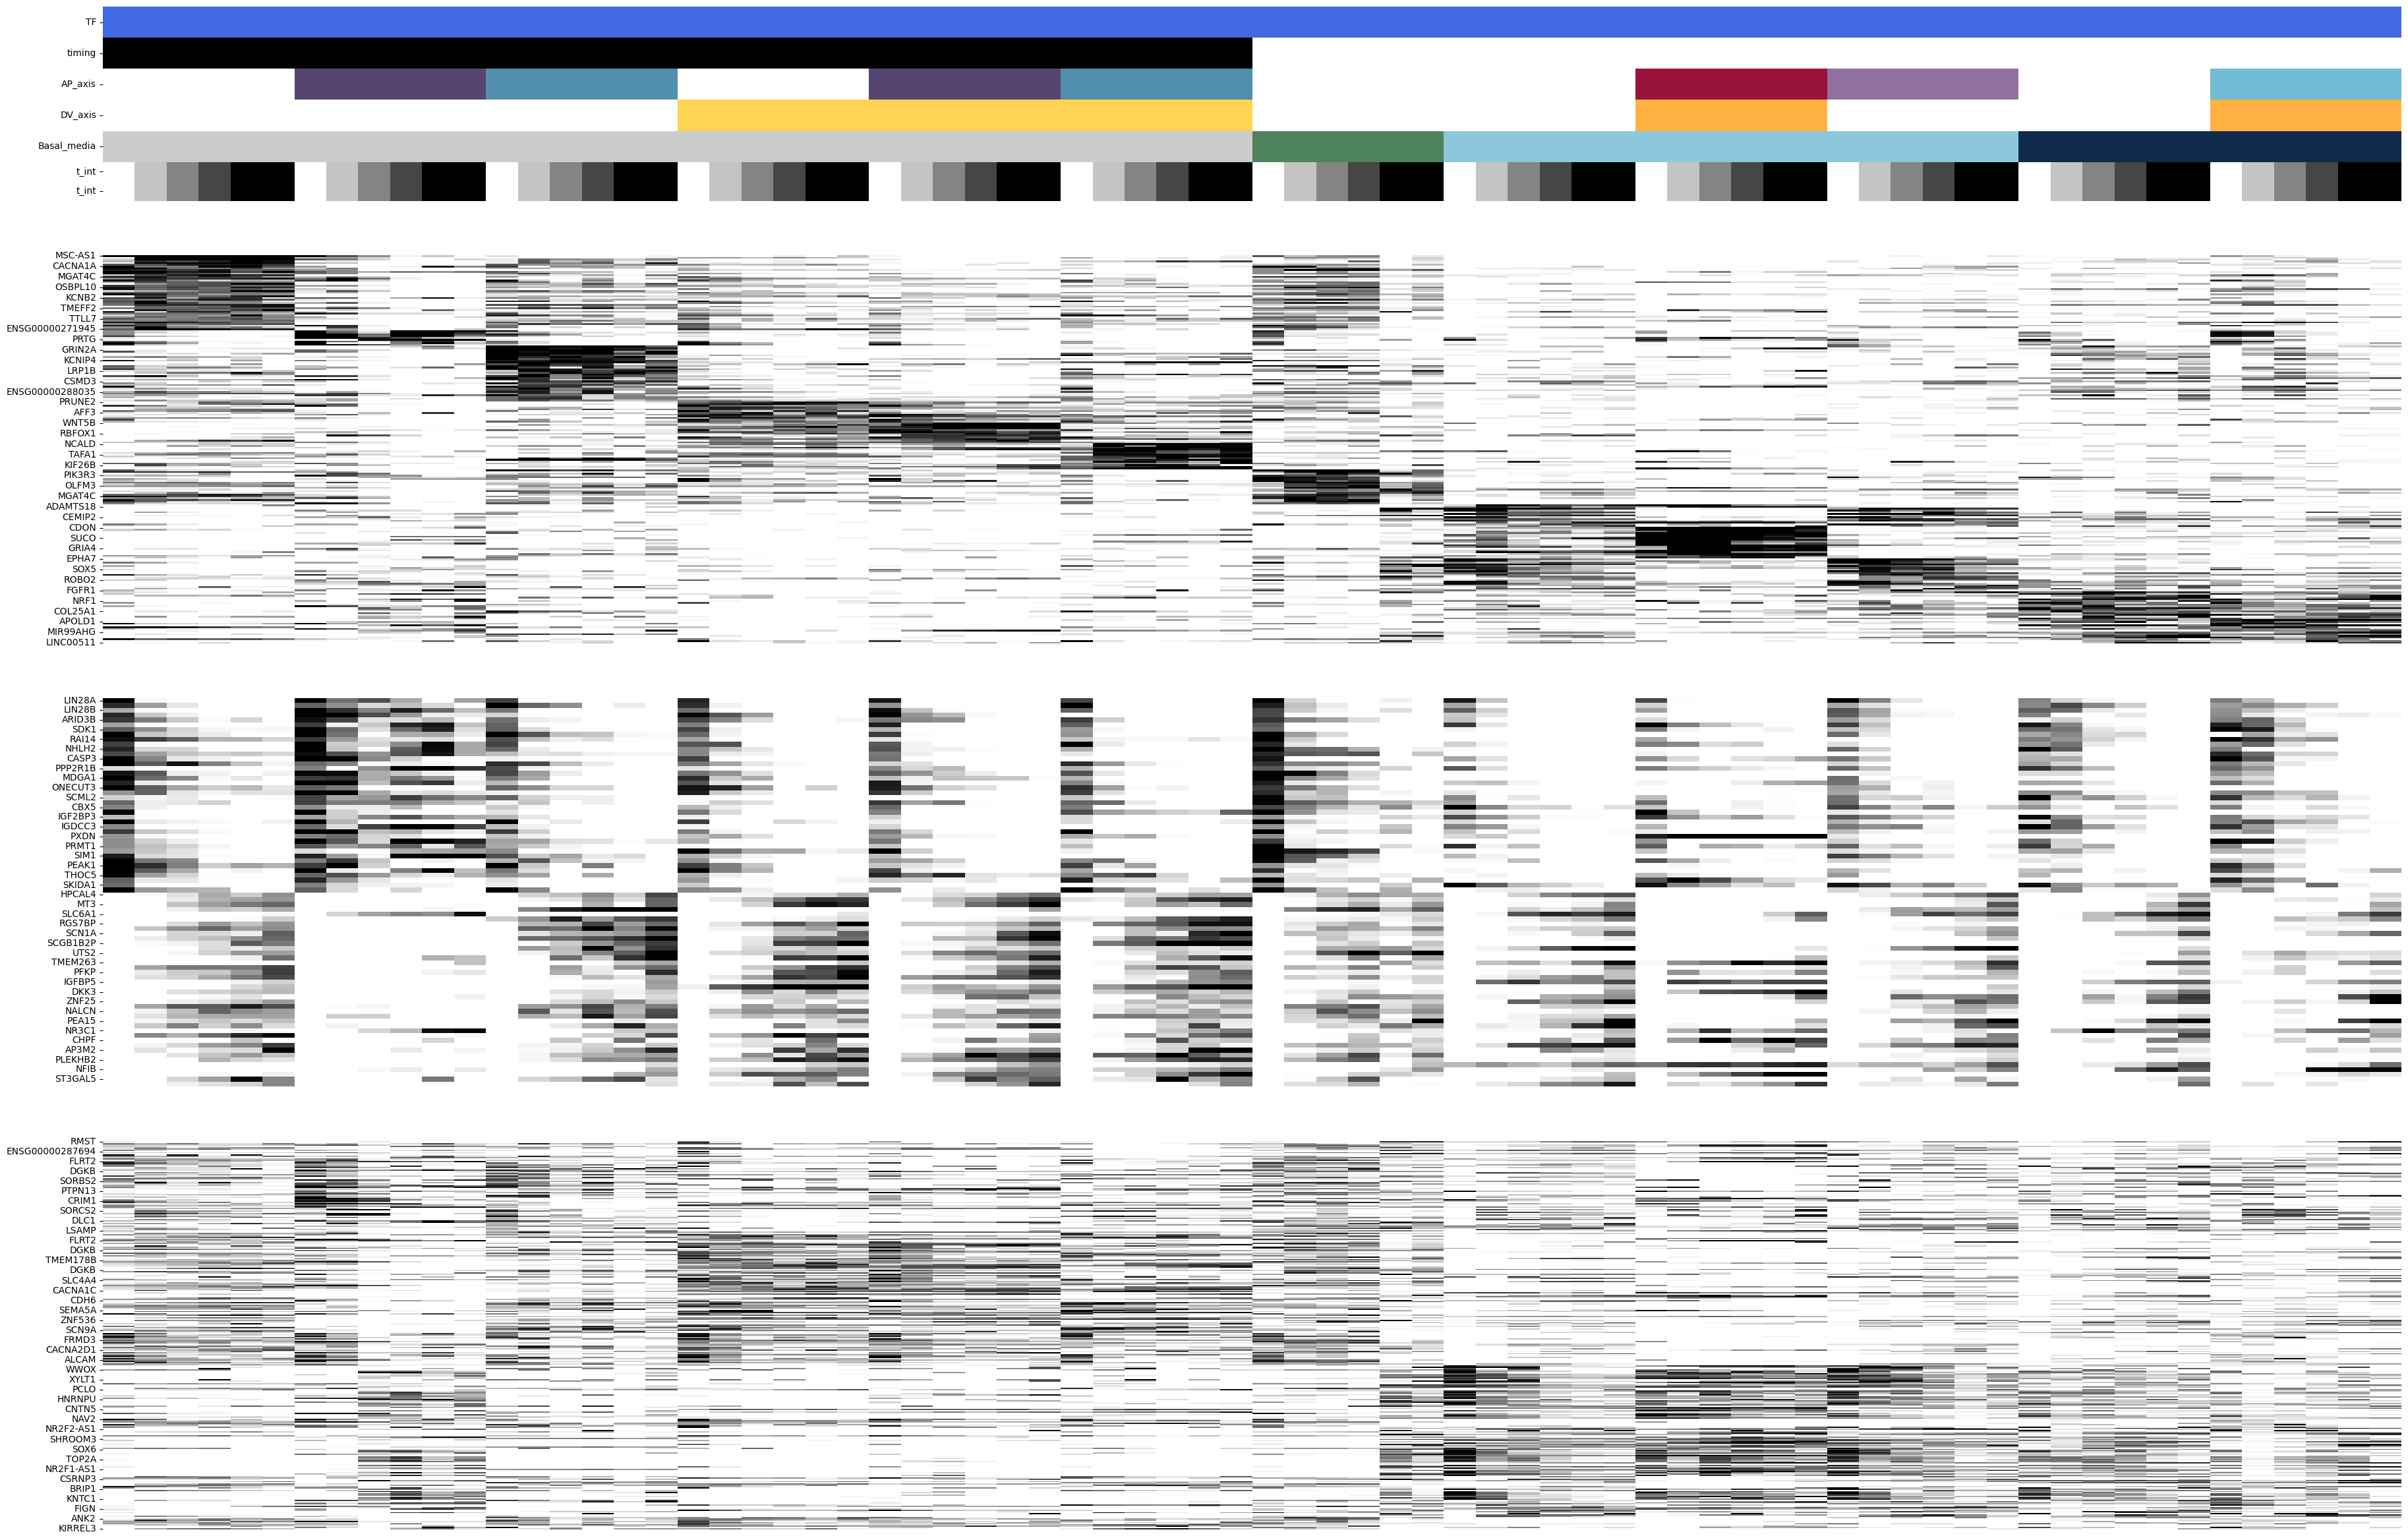

In [235]:
empty_space = 0.7
height_ratios = [2, #dendrogram 0,
                0.5, #time
                 empty_space,
                5, #heatmap1
                 empty_space,
                5, #heatmap 2
                 empty_space,
                5 #heatmap 3
                ]


white_axes = [2,4,6]
    
fig, axs = plt.subplots(len(height_ratios), 1, figsize=(45, 30), gridspec_kw={'height_ratios': height_ratios,
                                                           'hspace':0
                                                           })

# Dendrogram
ax_annotation = axs[0]
qualheatmap(bmeta.loc[sorted_samples_bulk,morphogens_summary].T,color_dict=color_dict,ax_heatmap=ax_annotation)
#ax_annotation.set_title('Annotation')
ax_annotation.set_xticks([])
#ax_annotation.set_yticks([])
ax_annotation.set_xticklabels([])
#ax_annotation.set_yticklabels([])

ax_timemap = axs[1]
sns.heatmap(bmeta.loc[bmeta.index,['t_int','t_int']].T,vmax=42,vmin=10,cmap='Greys',cbar=False,ax=ax_timemap)

# Heatmap 3
sc_markers_all_plot = [x for x in sc_markers_all if x not in time_genes]
sc_markers_all_plot = [x for x in sc_markers_all_plot if x not in stable_markers]

ax_heatmap1 = axs[3]
vsd_plot = vsd.loc[stable_markers,sorted_samples_bulk]
vsd_plot_Z = (vsd_plot.T-vsd_plot.T.mean())/vsd_plot.T.std()
sns.heatmap(vsd_plot_Z.T,vmin=0,vmax=2,cmap='Greys',cbar=False,ax=ax_heatmap1)
#ax_do.set_title('GO Disease')
ax_heatmap1.set_xticks([])
#ax_do.set_yticks([])
ax_heatmap1.set_xticklabels([])
#ax_do.set_yticklabels([])


# Heatmap 3
ax_heatmap2 = axs[5]
vsd_plot = vsd.loc[time_genes,sorted_samples_bulk]
vsd_plot_Z = (vsd_plot.T-vsd_plot.T.mean())/vsd_plot.T.std()
sns.heatmap(vsd_plot_Z.T,vmin=0,vmax=2,cmap='Greys',cbar=False,ax=ax_heatmap2)
#ax_do.set_title('GO Disease')
ax_heatmap2.set_xticks([])
#ax_do.set_yticks([])
ax_heatmap2.set_xticklabels([])
#ax_do.set_yticklabels([])

# Heatmap 3
ax_heatmap3 = axs[7]
vsd_plot = vsd.loc[sc_markers_all_plot,sorted_samples_bulk]
vsd_plot_Z = (vsd_plot.T-vsd_plot.T.mean())/vsd_plot.T.std()
sns.heatmap(vsd_plot_Z.T,vmin=0,vmax=2,cmap='Greys',cbar=False,ax=ax_heatmap3)
#ax_do.set_title('GO Disease')
ax_heatmap3.set_xticks([])
#ax_do.set_yticks([])
ax_heatmap3.set_xticklabels([])
#ax_do.set_yticklabels([])

for ax_white_nr in white_axes:
    ax_white = axs[ax_white_nr]
    ax_white.set_xticks([])
    ax_white.set_yticks([])
    ax_white.set_xticklabels([])
    ax_white.set_yticklabels([])
    sns.despine(left=True,bottom=True,ax=ax_white)

#plt.savefig("stability_plots/qual_heatmap_markers_greys.png",dpi=350,bbox_inches='tight',pad_inches=0)
plt.show()
plt.close()

In [ ]:
empty_space = 0.7
height_ratios = [5, #dendrogram 0,
                 5/3, #condition plot 1
                 5, #condition plot 2
                empty_space, #empty 3
                 1.4, #purity plot 4
                 empty_space, #empty 5 
                 6.5, #disease 6
                 empty_space, #empty 7
                 13] #gene expression 8


white_axes = [3,5,7]
    
fig, axs = plt.subplots(len(height_ratios), 1, figsize=(45, 30), gridspec_kw={'height_ratios': height_ratios,
                                                           'hspace':0
                                                           })

# Dendrogram
linked = linkage(cluster_avg_all_norm_use.T, method='complete', metric = 'cosine')
dendrogram(linked,ax=axs[0], labels=cluster_avg_all_norm_use.columns, leaf_rotation=90,color_threshold=0,above_threshold_color='k')
#axs[0].set_title('Dendrogram')
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].set_xticklabels([])
axs[0].set_yticklabels([])



ax_annotation = axs[1]
qualheatmap(annotation_df.loc[xlbls_names,['Division','Region','Neuron_type']].T,color_dict=color_dict_annots,ax_heatmap=ax_annotation)
#ax_annotation.set_title('Annotation')
ax_annotation.set_xticks([])
#ax_annotation.set_yticks([])
ax_annotation.set_xticklabels([])
#ax_annotation.set_yticklabels([])

ax_annotation = axs[2]
qualheatmap(df = cond_summary_plot.loc[xlbls_names,morph_axis].T,color_dict=color_dict,ax_heatmap=ax_annotation)
#ax_annotation.set_title('Annotation')
ax_annotation.set_xticks([])
#ax_annotation.set_yticks([])
ax_annotation.set_xticklabels([])
#ax_annotation.set_yticklabels([])


ax_purity = axs[4]
ax_purity.bar(x=sizes.index,height=sizes['size'],width=1,color='k')
ax_purity.set_xticks([])
ax_purity.set_yticks([0,1])
ax_purity.set_xticklabels([])
ax_purity.set_yticklabels([0,1])
ax_purity.set_xlim([sizes.index[0]-0.5,sizes.index[-1]+0.5])
sns.despine(left=False,bottom=True,ax=ax_purity)


# Heatmap 3
ax_do = axs[6]
sns.heatmap(go_summary.loc[xlbls_names,subset_terms].T,vmax=5,vmin=0,cmap='Reds',cbar=False,ax=ax_do)
#ax_do.set_title('GO Disease')
ax_do.set_xticks([])
#ax_do.set_yticks([])
ax_do.set_xticklabels([])
#ax_do.set_yticklabels([])


ax_gene = axs[8]
plotting_genes_plot = [x for x in plotting_genes if x!='MAP2']
sns.heatmap(cluster_avg_all_norm_Z.loc[plotting_genes_plot,xlbls_names],vmin=-2,vmax=2,cmap='RdBu_r',cbar=False,ax=ax_gene)
#ax_gene.set_title('GO Disease')
ax_gene.set_xticks([])
#ax_gene.set_yticks([])
ax_gene.set_xticklabels([])
#ax_gene.set_yticklabels([])

for ax_white_nr in white_axes:
    ax_white = axs[ax_white_nr]
    ax_white.set_xticks([])
    ax_white.set_yticks([])
    ax_white.set_xticklabels([])
    ax_white.set_yticklabels([])
    sns.despine(left=True,bottom=True,ax=ax_white)

plt.savefig("figures/dendrogram/combined_plot_onlyNeur_ratios_annot.png",dpi=350,bbox_inches='tight',pad_inches=0)
#plt.savefig("figures/dendrogram/combined_plot_onlyNeur_ratios_hr_annot.png",dpi=1000,bbox_inches='tight',pad_inches=0)
plt.show()
plt.close()

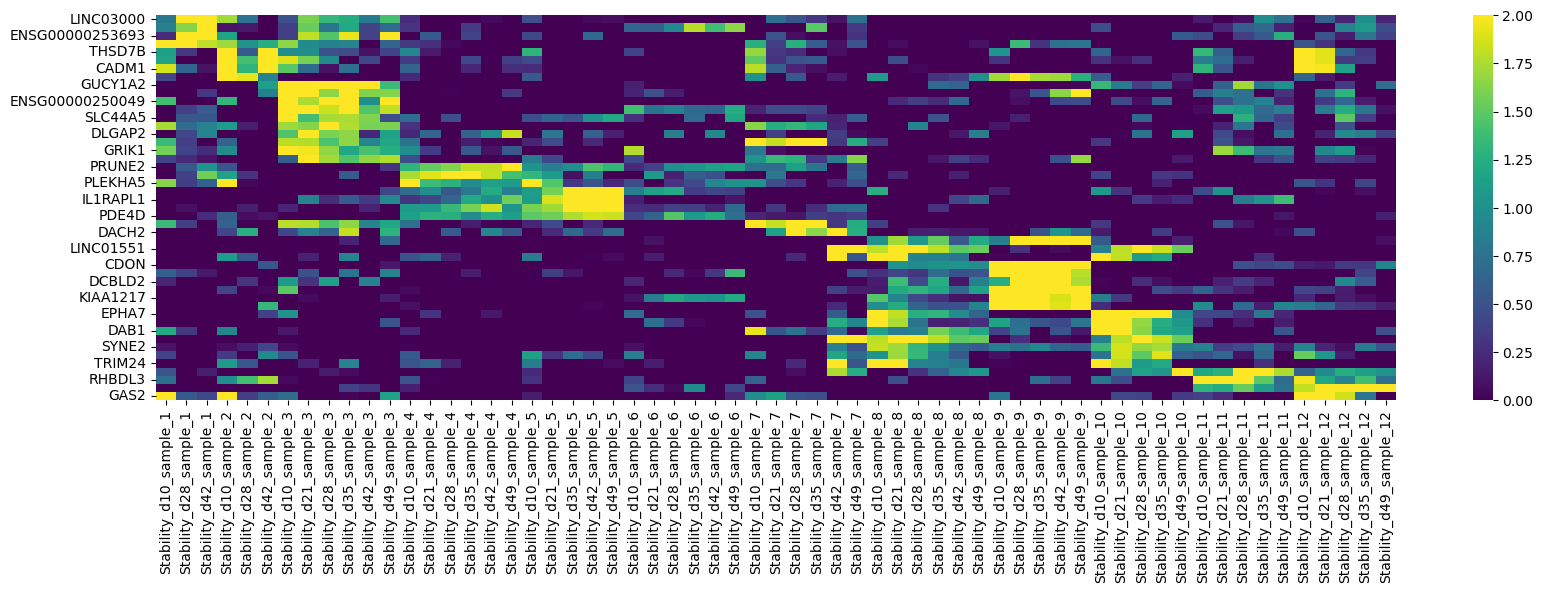

In [70]:
vsd_plot = vsd.loc[sample_markers_all_bulk_sc,sorted_samples]
vsd_plot_Z = (vsd_plot.T-vsd_plot.T.mean())/vsd_plot.T.std()
plt.figure(figsize=(20,5))
sns.heatmap(vsd_plot_Z.T,vmin=0,vmax=2,cmap='viridis')
#plt.savefig("stability_plots/sample_heatmap_markers_sorted.png",dpi=350,bbox_inches='tight',pad_inches=0)
plt.show()
plt.close()



In [26]:
df

,Stability_d21_sample_9,Stability_d21_sample_4,Stability_d21_sample_5,Stability_d21_sample_10,Stability_d21_sample_7,Stability_d21_sample_6,Stability_d21_sample_1,Stability_d21_sample_12,Stability_d21_sample_3,Stability_d21_sample_2,...,Stability_d28_sample_10,Stability_d28_sample_11,Stability_d28_sample_1,Stability_d28_sample_2,Stability_d28_sample_3,Stability_d28_sample_12,Stability_d28_sample_8,Stability_d28_sample_7,Stability_d28_sample_6,Stability_d28_sample_5
Stability_d21_sample_9,0.000000,124.905865,119.896031,87.095751,126.402321,116.274745,125.622358,93.464888,124.418175,117.418188,...,92.504580,89.692905,125.878066,98.232673,118.709691,94.689391,86.533173,129.441507,120.768796,123.280530
Stability_d21_sample_4,124.905865,0.000000,54.346609,95.987087,67.158145,65.666217,67.657586,85.849969,67.156318,74.010430,...,92.216733,97.515043,63.315198,88.088846,70.468768,85.966762,93.814051,66.105836,66.445449,58.722100
Stability_d21_sample_5,119.896031,54.346609,0.000000,94.741266,69.979422,69.136228,75.668971,86.564655,72.229308,70.783436,...,91.724354,95.307915,71.946115,81.117994,74.061898,86.435682,93.874160,71.230522,73.017627,46.129373
Stability_d21_sample_10,87.095751,95.987087,94.741266,0.000000,92.183140,98.282883,91.227105,68.262929,92.996966,86.902335,...,45.792693,62.066818,93.112970,70.528450,89.599523,69.247759,52.950684,95.829518,102.634011,99.519031
Stability_d21_sample_7,126.402321,67.158145,69.979422,92.183140,0.000000,81.748135,60.668117,85.417813,64.717271,70.137531,...,86.020714,93.822929,56.014730,84.912331,64.065353,84.193632,92.409329,49.617167,85.499832,76.224352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Stability_d28_sample_12,94.689391,85.966762,86.435682,69.247759,84.193632,82.383710,80.527132,47.743644,78.230552,78.677441,...,69.752924,57.052437,83.299607,75.652879,74.455048,0.000000,74.389133,91.653656,90.350636,94.530849
Stability_d28_sample_8,86.533173,93.814051,93.874160,52.950684,92.409329,97.698648,89.551568,69.551736,88.658856,84.152921,...,56.957542,69.342079,93.906712,76.807760,90.231312,74.389133,0.000000,95.105306,101.846463,99.543073
Stability_d28_sample_7,129.441507,66.105836,71.230522,95.829518,49.617167,84.003971,61.653106,88.138482,65.517841,69.609416,...,94.404090,102.543264,59.319910,88.935185,70.689125,91.653656,95.105306,0.000000,84.412169,76.210358
Stability_d28_sample_6,120.768796,66.445449,73.017627,102.634011,85.499832,46.381976,83.959594,87.927931,76.180691,86.931442,...,103.792056,104.395444,80.172495,99.073099,80.907204,90.350636,101.846463,84.412169,0.000000,74.735789


In [20]:
# Sample data
data = np.random.rand(10, 4)  # 10 samples, 4 features

# Perform hierarchical clustering
linkage_matrix = sch.linkage(data, method='ward')


# Create the dendrogram with custom leaf label colors
dendrogram = sch.dendrogram(
    linkage_matrix,
    leaf_rotation=90,  # Rotate leaf labels for better readability
    leaf_font_size=12  # Font size for leaf labels
)

# Manually color the leaves
ax = plt.gca()
x_labels = ax.get_xmajorticklabels()
for label in x_labels:
    txt = label.get_text()
    color_code = leaf_colors[txt]
    label.set_color(color_code)

plt.show()


KeyError: 1

In [76]:
def leaf_label_func(id):
    return f'[{leaf_colors[id]}]{id}'


In [13]:
# Define a custom leaf label function
def leaf_label_func(id):
    leaf_colors = {'Stability_d21_sample_1': 'red',
                 'Stability_d49_sample_1': 'red',
                 'Stability_d35_sample_1': 'red',
                 'Stability_d42_sample_1': 'red',
                 'Stability_d10_sample_1': 'red',
                 'Stability_d28_sample_1': 'red',
                 'Stability_d21_sample_2': 'green',
                 'Stability_d49_sample_2': 'green',
                 'Stability_d35_sample_2': 'green',
                 'Stability_d42_sample_2': 'green',
                 'Stability_d10_sample_2': 'green',
                 'Stability_d28_sample_2': 'green',
                 'Stability_d21_sample_3': 'blue',
                 'Stability_d49_sample_3': 'blue',
                 'Stability_d35_sample_3': 'blue',
                 'Stability_d42_sample_3': 'blue',
                 'Stability_d10_sample_3': 'blue',
                 'Stability_d28_sample_3': 'blue',
                 'Stability_d21_sample_4': 'cyan',
                 'Stability_d49_sample_4': 'cyan',
                 'Stability_d35_sample_4': 'cyan',
                 'Stability_d42_sample_4': 'cyan',
                 'Stability_d10_sample_4': 'cyan',
                 'Stability_d28_sample_4': 'cyan',
                 'Stability_d21_sample_5': 'magenta',
                 'Stability_d49_sample_5': 'magenta',
                 'Stability_d35_sample_5': 'magenta',
                 'Stability_d42_sample_5': 'magenta',
                 'Stability_d10_sample_5': 'magenta',
                 'Stability_d28_sample_5': 'magenta',
                 'Stability_d21_sample_6': 'yellow',
                 'Stability_d49_sample_6': 'yellow',
                 'Stability_d35_sample_6': 'yellow',
                 'Stability_d42_sample_6': 'yellow',
                 'Stability_d10_sample_6': 'yellow',
                 'Stability_d28_sample_6': 'yellow',
                 'Stability_d21_sample_7': 'black',
                 'Stability_d49_sample_7': 'black',
                 'Stability_d35_sample_7': 'black',
                 'Stability_d42_sample_7': 'black',
                 'Stability_d10_sample_7': 'black',
                 'Stability_d28_sample_7': 'black',
                 'Stability_d21_sample_8': 'white',
                 'Stability_d49_sample_8': 'white',
                 'Stability_d35_sample_8': 'white',
                 'Stability_d42_sample_8': 'white',
                 'Stability_d10_sample_8': 'white',
                 'Stability_d28_sample_8': 'white',
                 'Stability_d21_sample_9': 'orange',
                 'Stability_d49_sample_9': 'orange',
                 'Stability_d35_sample_9': 'orange',
                 'Stability_d42_sample_9': 'orange',
                 'Stability_d10_sample_9': 'orange',
                 'Stability_d28_sample_9': 'orange',
                 'Stability_d21_sample_10': 'purple',
                 'Stability_d49_sample_10': 'purple',
                 'Stability_d35_sample_10': 'purple',
                 'Stability_d42_sample_10': 'purple',
                 'Stability_d10_sample_10': 'purple',
                 'Stability_d28_sample_10': 'purple',
                 'Stability_d21_sample_11': 'brown',
                 'Stability_d49_sample_11': 'brown',
                 'Stability_d35_sample_11': 'brown',
                 'Stability_d42_sample_11': 'brown',
                 'Stability_d10_sample_11': 'brown',
                 'Stability_d28_sample_11': 'brown',
                 'Stability_d21_sample_12': 'pink',
                 'Stability_d49_sample_12': 'pink',
                 'Stability_d35_sample_12': 'pink',
                 'Stability_d42_sample_12': 'pink',
                 'Stability_d10_sample_12': 'pink',
                 'Stability_d28_sample_12': 'pink'}


    return f'[{leaf_colors[id]}]{id}'


# Create the dendrogram with custom leaf label colors
dendrogram = sch.dendrogram(
    linkage_matrix,
    leaf_label_func=leaf_label_func,
    leaf_rotation=90,  # Rotate leaf labels for better readability
    leaf_font_size=12  # Font size for leaf labels
)


dendrogram_labels = df.index[dendrogram['leaves']]



KeyError: 47

In [86]:
# Create the dendrogram with custom leaf label colors
dendrogram = sch.dendrogram(
    df,
    labels=df.index,
)



ValueError: Dimensions of Z and labels must be consistent.

In [57]:
vsd_plot = vsd.loc[sample_markers_all,dendrogram_labels]
vsd_plot_Z = (vsd_plot.T-vsd_plot.T.mean())/vsd_plot.T.std()

plt.figure(figsize=(20,5))
sns.heatmap(vsd_plot_Z.T,vmin=0,vmax=2)

<Axes: >

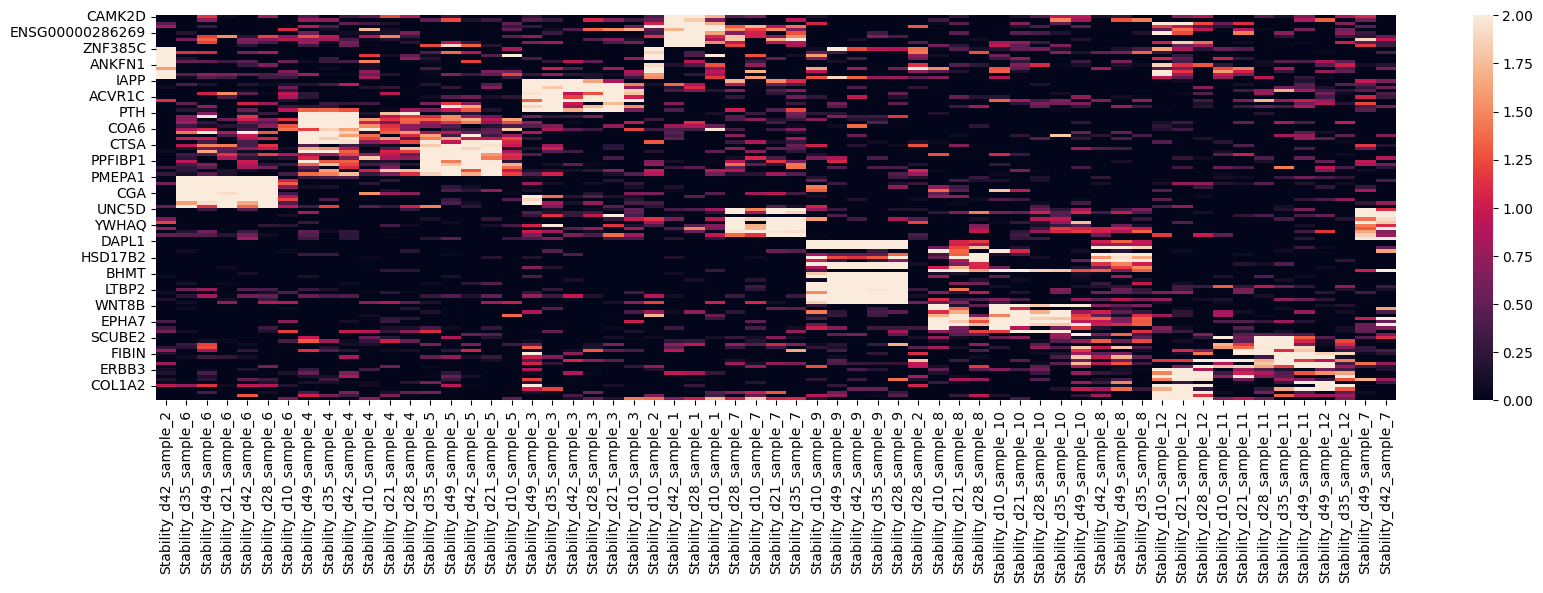

In [88]:
# Perform hierarchical clustering using the distance matrix
linked = sch.linkage(distance_matrix, method='complete')


/tmp/ipykernel_23962/3190910593.py:2: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linked = sch.linkage(distance_matrix, method='complete')


,Stability_d21_sample_4,Stability_d21_sample_5,Stability_d21_sample_10,Stability_d21_sample_7,Stability_d21_sample_6,Stability_d21_sample_12,Stability_d21_sample_3,Stability_d21_sample_11,Stability_d21_sample_8,Stability_d49_sample_4,...,Stability_d28_sample_9,Stability_d28_sample_10,Stability_d28_sample_11,Stability_d28_sample_1,Stability_d28_sample_2,Stability_d28_sample_3,Stability_d28_sample_12,Stability_d28_sample_8,Stability_d28_sample_7,Stability_d28_sample_6
Stability_d21_sample_4,0.000000,67.782094,115.101891,82.523176,80.502424,103.971158,82.522993,112.171177,123.012091,72.505498,...,146.309302,110.865376,116.654967,77.412260,107.327794,84.765478,103.708090,112.615685,80.412650,80.515964
Stability_d21_sample_5,67.782094,0.000000,113.158812,85.359722,84.064952,104.280456,87.863328,109.050005,119.591049,73.730530,...,140.666440,109.917487,113.817769,87.318636,99.138383,89.006898,103.894902,112.329630,86.002927,87.810426
Stability_d21_sample_10,115.101891,113.158812,0.000000,110.364017,117.169863,83.047050,111.667214,74.853558,60.713964,120.229177,...,100.400945,56.782005,75.250551,110.849985,86.399418,106.207441,83.058510,64.761733,113.141966,120.949712
Stability_d21_sample_7,82.523176,85.359722,110.364017,0.000000,98.640491,103.280597,79.534203,109.246944,119.852087,91.271725,...,146.542073,103.525426,112.287712,69.080198,103.497069,77.287892,101.695766,110.826150,61.539714,102.271311
Stability_d21_sample_6,80.502424,84.064952,117.169863,98.640491,0.000000,102.323896,88.375818,110.292680,119.645411,89.073734,...,139.957723,114.232107,113.009625,93.651415,110.408458,91.303309,99.321278,116.784170,100.772621,56.767881
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Stability_d28_sample_3,84.765478,89.006898,106.207441,77.287892,91.303309,88.562861,62.843063,95.791416,114.034644,91.241696,...,141.241480,104.718965,104.101528,74.185320,107.093324,0.000000,91.311161,108.707402,86.036784,97.687929
Stability_d28_sample_12,103.708090,103.894902,83.058510,101.695766,99.321278,59.311254,94.972293,67.586451,86.858233,110.014706,...,113.536570,85.124346,70.526872,101.469965,91.854303,91.311161,0.000000,90.362024,110.337752,108.865110
Stability_d28_sample_8,112.615685,112.329630,64.761733,110.826150,116.784170,84.343329,106.810143,77.590665,62.285232,122.670429,...,102.161014,70.336857,84.346019,113.025662,92.972649,108.707402,90.362024,0.000000,113.860567,121.664447
Stability_d28_sample_7,80.412650,86.002927,113.141966,61.539714,100.772621,105.350942,79.716192,111.257868,122.801125,90.560333,...,153.129456,112.679775,121.935942,73.322110,106.582014,86.036784,110.337752,113.860567,0.000000,102.136898


/tmp/ipykernel_23962/3114295786.py:17: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linked = sch.linkage(distance_matrix, method='complete')


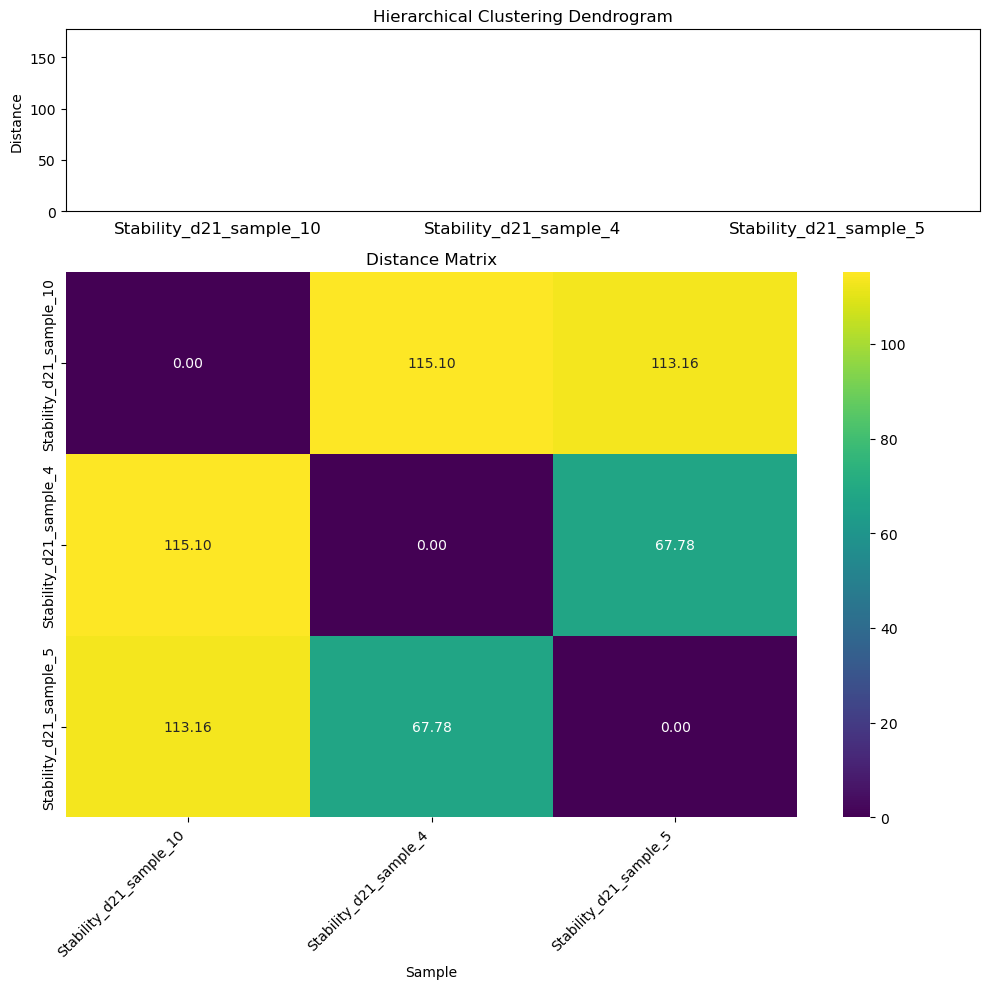

In [30]:
import numpy as np
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
import seaborn as sns

# Distance matrix as a numpy array
distance_matrix = np.array([
    [0.000000, 67.782094, 115.101891],
    [67.782094, 0.000000, 113.158812],
    [115.101891, 113.158812, 0.000000]
])

# Sample labels
labels = ["Stability_d21_sample_4", "Stability_d21_sample_5", "Stability_d21_sample_10"]

# Perform hierarchical clustering using the distance matrix
linked = sch.linkage(distance_matrix, method='complete')

# Create a figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), gridspec_kw={'height_ratios': [1, 3]}, sharex=True)

# Plot the dendrogram on the first subplot
dendrogram = sch.dendrogram(linked, labels=labels, ax=ax1)
ax1.set_title('Hierarchical Clustering Dendrogram')
ax1.set_ylabel('Distance')

# Reorder the distance matrix according to the dendrogram leaves
dendro_order = dendrogram['leaves']
ordered_distance_matrix = distance_matrix[dendro_order, :][:, dendro_order]
ordered_labels = [labels[i] for i in dendro_order]

# Plot the distance matrix as a heatmap on the second subplot
sns.heatmap(ordered_distance_matrix, annot=True, fmt=".2f", cmap='viridis', xticklabels=ordered_labels, yticklabels=ordered_labels, ax=ax2)
ax2.set_title('Distance Matrix')
ax2.set_xlabel('Sample')

# Rotate x-axis labels for better readability
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

# Adjust layout to make room for labels
plt.tight_layout()

# Show the plot
plt.show()


## Analysis Summary and Session Information

This notebook completed a comprehensive stability analysis of bulk RNA-seq data with single cell integration:

### Key Results:
1. **Hierarchical Clustering**: Ward linkage clustering revealed sample relationships and temporal patterns
2. **Temporal Distance Analysis**: Distance trajectories showed stability patterns across developmental timepoints  
3. **Marker Gene Analysis**: Identified and visualized key markers from both bulk differential expression and single cell data
4. **Expression Heatmaps**: Generated comprehensive heatmaps for different gene sets (bulk markers, SC markers, temporal genes)

### Output Files Generated:
- `stability_plots/dendrogram_colored_by_sample_noFilter_wSC.png`: Hierarchical clustering dendrogram
- `stability_plots/temporal_distance_plots_*.png`: Distance vs time plots for sample groups
- `stability_plots/sample_heatmap_*.png`: Expression heatmaps for various gene sets

### Analysis Parameters:
- Distance metric: Ward linkage on PCA-corrected distances (no filter, with single cells)
- Top markers per sample: {N_TOP_MARKERS}
- Temporal genes analyzed: {N_TIME_GENES} early/late genes
- Timepoints analyzed: {TIMEPOINTS}

The analysis successfully integrated bulk and single cell data to provide comprehensive insights into developmental stability patterns.

In [ ]:
# =============================================================================
# SESSION INFORMATION FOR REPRODUCIBILITY
# =============================================================================

import datetime
import sys
import platform

print("="*80)
print("SESSION INFORMATION")
print("="*80)
print(f"Analysis completed: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Python version: {sys.version}")
print(f"Platform: {platform.platform()}")
print(f"Working directory: {os.getcwd()}")
print()

print("PACKAGE VERSIONS:")
print("-" * 40)
try:
    import pkg_resources
    packages = ['pandas', 'numpy', 'matplotlib', 'seaborn', 'scipy']
    for package in packages:
        try:
            version = pkg_resources.get_distribution(package).version
            print(f"{package}: {version}")
        except:
            print(f"{package}: version not found")
except ImportError:
    print("pkg_resources not available for version checking")

print()
print("ANALYSIS PARAMETERS:")
print("-" * 40)
print(f"Random seed: 42")
print(f"Distance file: {DISTANCE_FILE}")
print(f"Number of samples analyzed: {len(meta) if 'meta' in locals() else 'N/A'}")
print(f"Number of genes in expression data: {len(expr.index) if 'expr' in locals() else 'N/A'}")
print(f"Output directory: {OUTPUT_DIR}")
print(f"DPI for plots: {DPI}")
print("="*80)